In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont

def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
    plt.close()

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

In [3]:
# data = [
#     ['148_2_2', 4],
#     ['136_1_3', 4],
#     ['136_1_4', 5],
#     ['149_1_1', 4],
#     ['149_1_2', 5],
#     ['162_1_3', 3],
#     ['178_1_4', 4],
#     ['178_1_5', 3],
#     ['178_1_6', 4],
#     ['178_1_7', 4],
#     ['178_1_8', 4],
#     ['178_1_9', 3],
#     ['178_2_1', 3],
#     ['178_2_2', 3],
#     ['178_2_3', 4],
#     ['178_2_4', 4],
#     ['EJT268_1_10', 3],
#     ['EJT269_1_7', 4],
#     ['EJT270_1_5', 4]
# ]

In [4]:
mouse_session_recording = '178_1_7'
region = 'striatum'

## PATHS
PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"



## set ppseq file
for file_ in os.listdir(PP_PATH):
    if mouse_session_recording in file_:
        file = file_
        
save_path = PP_PATH + file + '\\analysis_output\\'
save_path = save_path + 'latent_composition_analysis\\'
        
## set dat_path:
for file_ in os.listdir(DAT_PATH):
    if mouse_session_recording.split('_')[0] in file_:
        if mouse_session_recording.split('_')[1] == file_[-1]:
            dat_path = os.path.join(DAT_PATH,file_)
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][-1] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)
        
# set tracking path
for file_ in os.listdir(dat_path + r"\video\tracking\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
# set video paths
for file_ in os.listdir(dat_path + r"\video\videos\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
            for vid_file in os.listdir(cam_path):
                if 'back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'side' in vid_file and '.avi' in vid_file:
                    side_cam_avi_path = os.path.join(cam_path,vid_file)

In [5]:

print('\n')
print("LOADING processed_spike_data")
### load in releavent things:

import pickle
with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    unmasked_spikes_df = pickle.load(input_file)

with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_order"), "rb") as input_file:
    neuron_order = pickle.load(input_file)
    
with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\colors"), "rb") as input_file:
    colors = pickle.load(input_file)
    
with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_index"), "rb") as input_file:
    neuron_index = pickle.load(input_file)
    
with open(PP_PATH + file + "\\analysis_output\\" + "latent_event_history_df_split.pickle", "rb") as input_file:
    latent_event_history_df_split = pickle.load(input_file)

ordered_preferred_type = np.load(PP_PATH + file + "\\analysis_output\\" + 'ordered_preferred_type.npy')

bkgd_log_proportions_array = pd.read_csv(PP_PATH + file + r"\bkgd_log_proportions_array.csv")

neuron_response_df = pd.read_csv(PP_PATH + file + r"\neuron_response.csv")


##### load deeplabcut tracking data
print('\n')
print("LOADING DLC TRACKING DATA")
back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')
back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')


## load in the timespan used for pppseq:
input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
# Opening JSON file
f = open(input_params_path)
# returns JSON object as  a dictionary
input_config = json.load(f)
behav_time_interval_start = input_config['time_span'][0]
print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")


## LOAD behaviour data
print('\n')
print("LOADING BEHAV DATA")
behav_sync = pd.read_csv(dat_path + r'\behav_sync\2_task\Behav_Ephys_Camera_Sync.csv')
transitions = pd.read_csv(dat_path + r'\behav_sync\2_task\Transition_data_sync.csv')

behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
ports = behav_sync[behav_mask].Port
print('done')




LOADING processed_spike_data


LOADING DLC TRACKING DATA
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5
['head_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5
      A corresponding time span has been found. Time span set to [5400, 6000]


LOADING BEHAV DATA
done


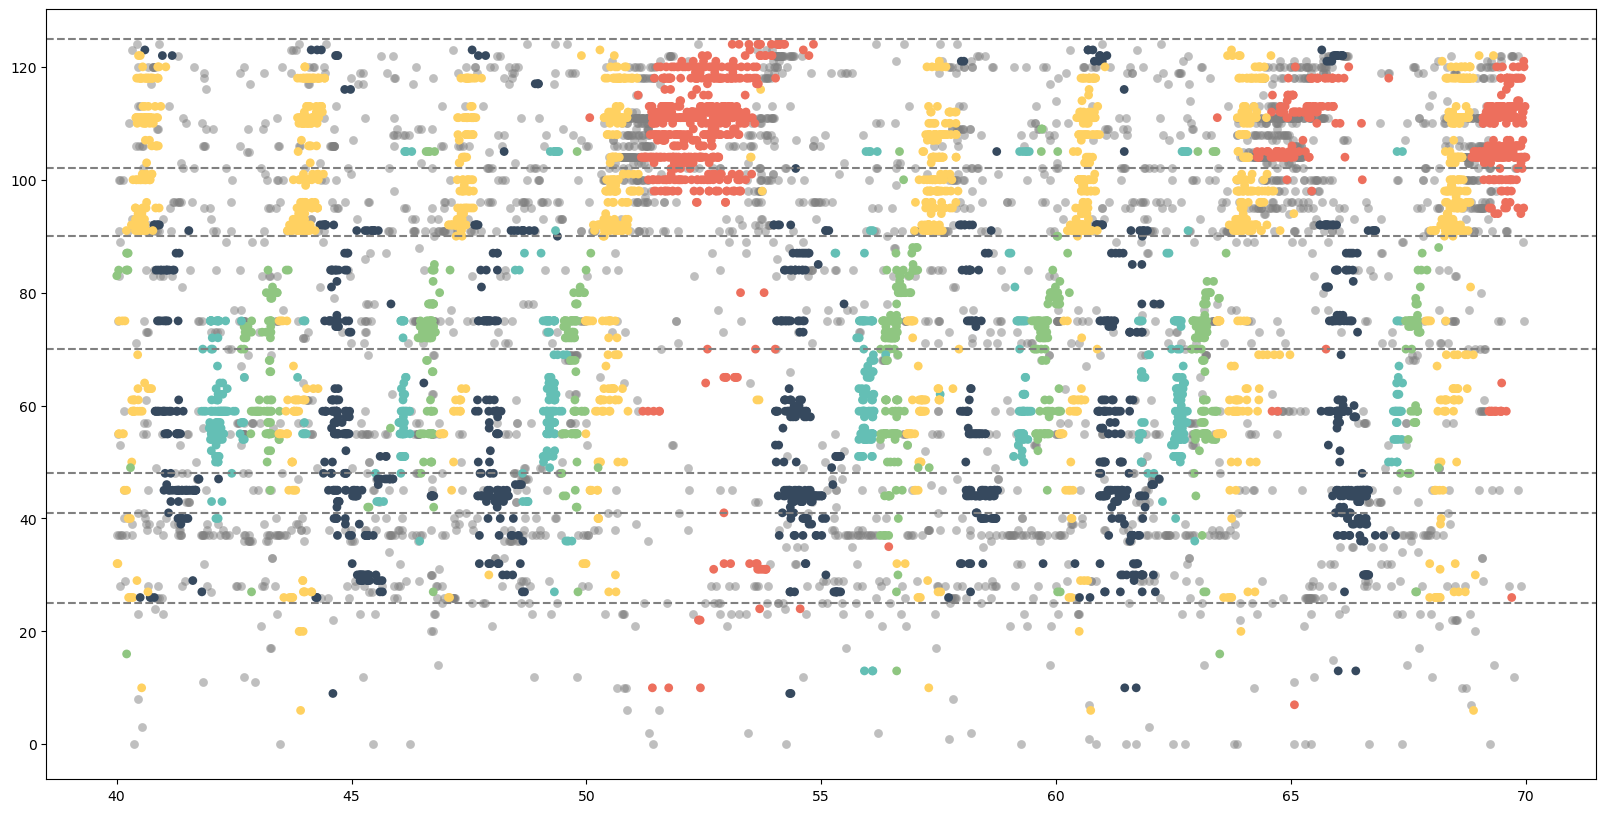

In [6]:
### Plot sequences - basic
timeframe = [40,70]
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

fig, ax = plt.subplots(1, 1,figsize=(20, 10))

# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

### add chunk lines:
## work out ordering chunk sizes
split_lists = split_list(ordered_preferred_type[neuron_index])
lens = []
for list_ in split_lists:
    lens += [len(list_)]
chunks = [sum(lens[0:int(np.unique(ordered_preferred_type)[-1]+1)])] + lens[int(np.unique(ordered_preferred_type)[-1]+1)::] 

## plot seq divding lines:
for i in range(len(chunks)):
    ax.axhline(y = np.cumsum(chunks)[i], color = 'grey', linestyle = '--')



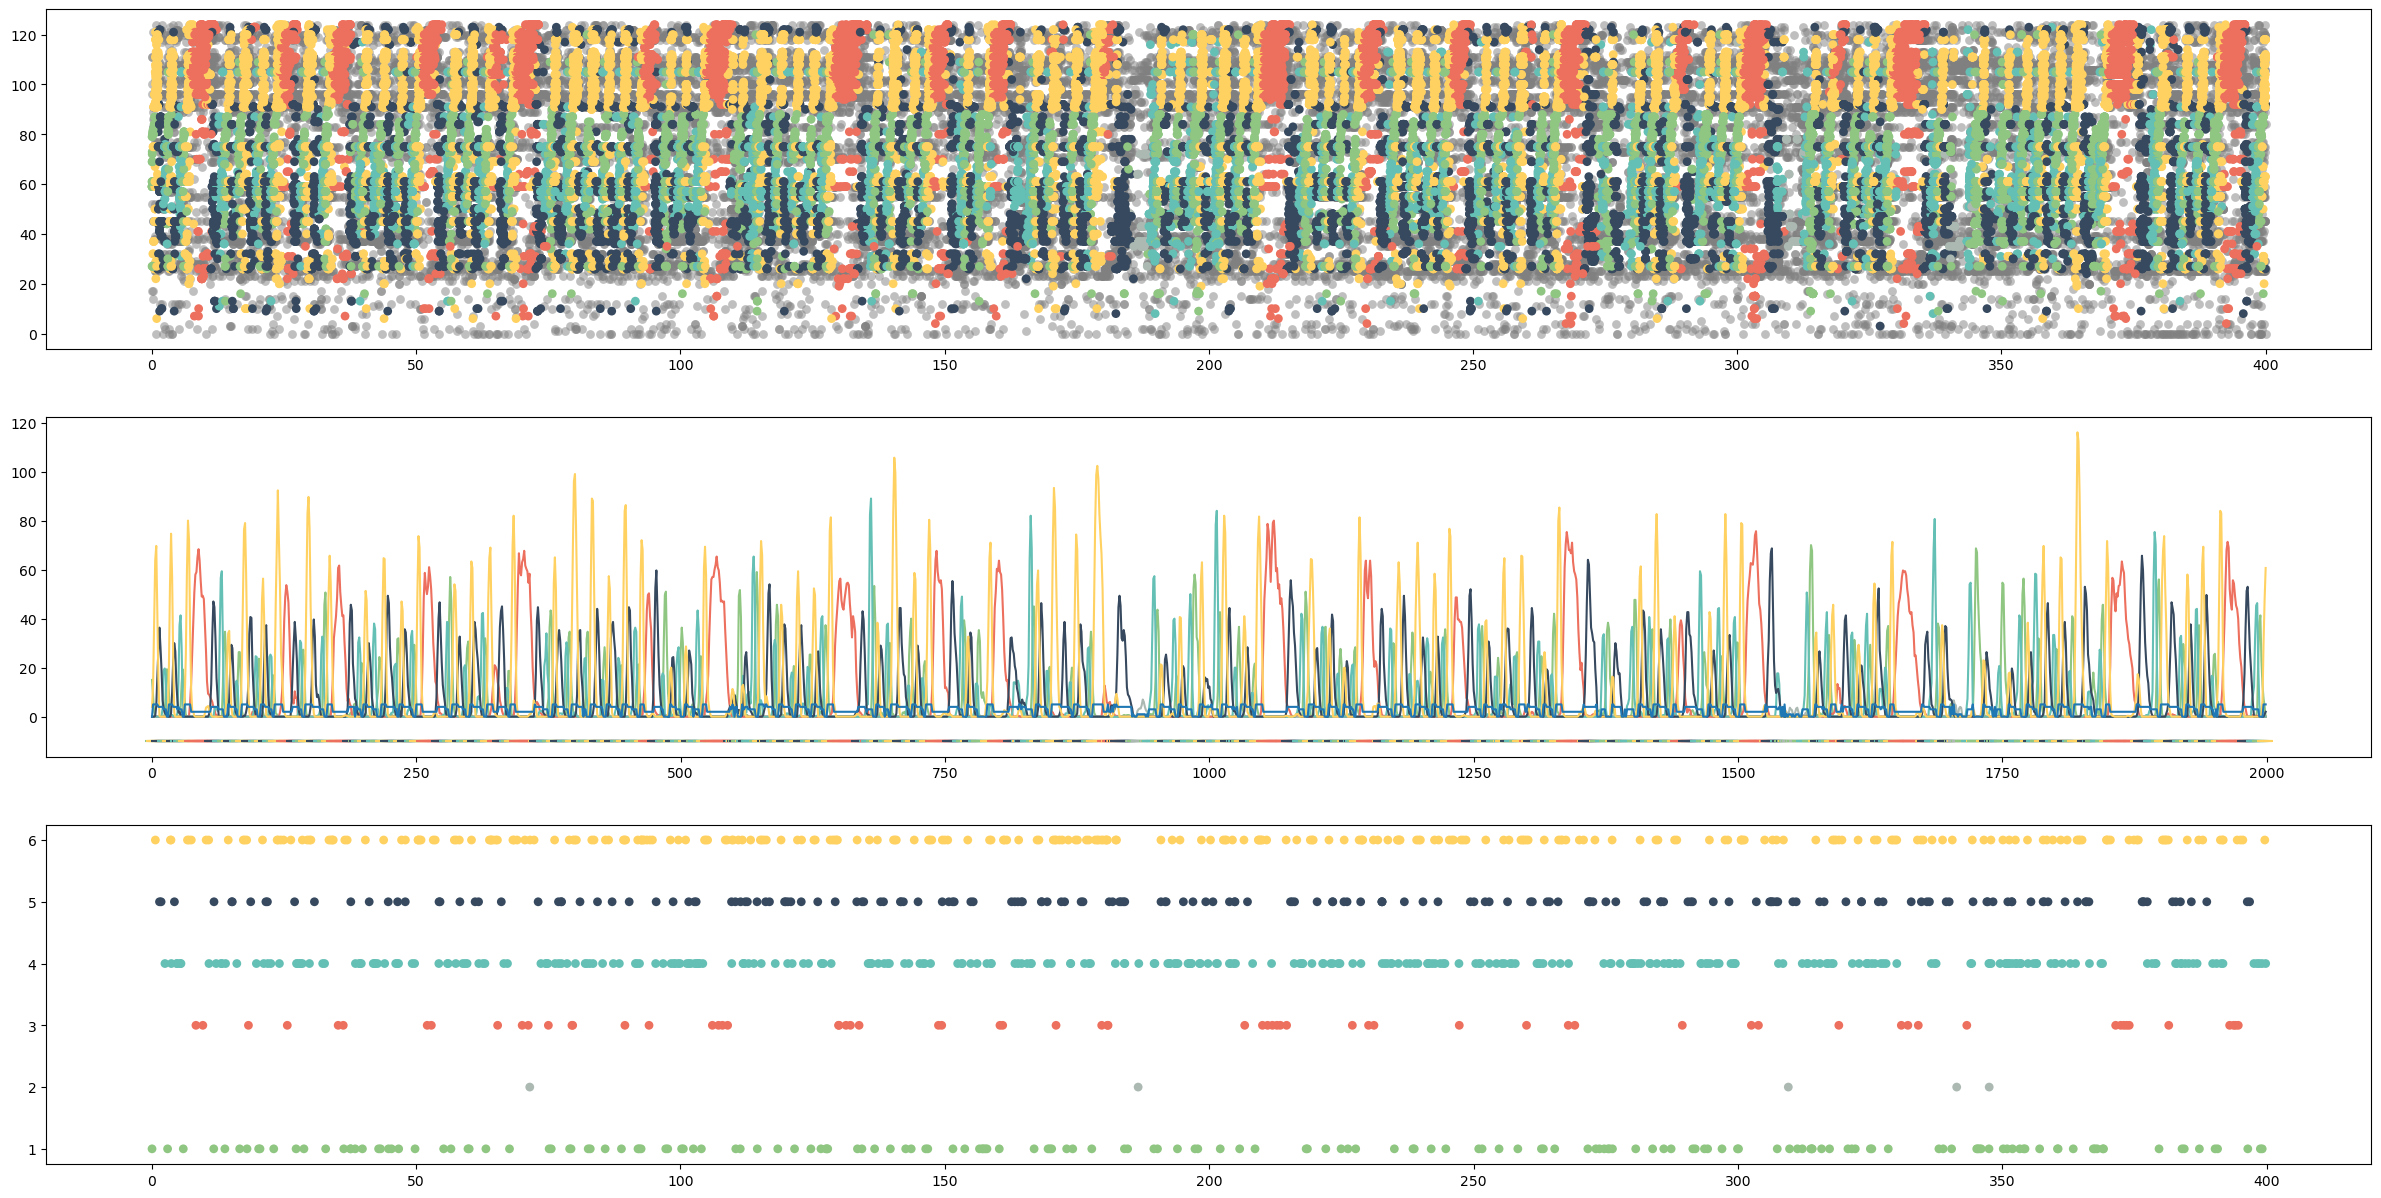

In [7]:
timeframe = [0,400]

#mask
# spikemask
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

1 ### plot ordered ppseq spikes as above:

# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# mask to remove background neurons from the color plot
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

# Define the bin size (in this case, 0.2s)
bin_size = 0.2

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]
    
strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

for i in range (1,len(seq_spike_occurance)):
#     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
    ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])
    

## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

ax2.plot(max_index[strt_:end_])

ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

### plot the ppseq latent:

# mask for the timespan
latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

# ignore anything that is below threshold * max amplitude
thr_ = 0
thresh_value = max(latent_event_history_df_split.amplitude) * thr_


amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


# SaveFig('seq_identities.png',save_path)

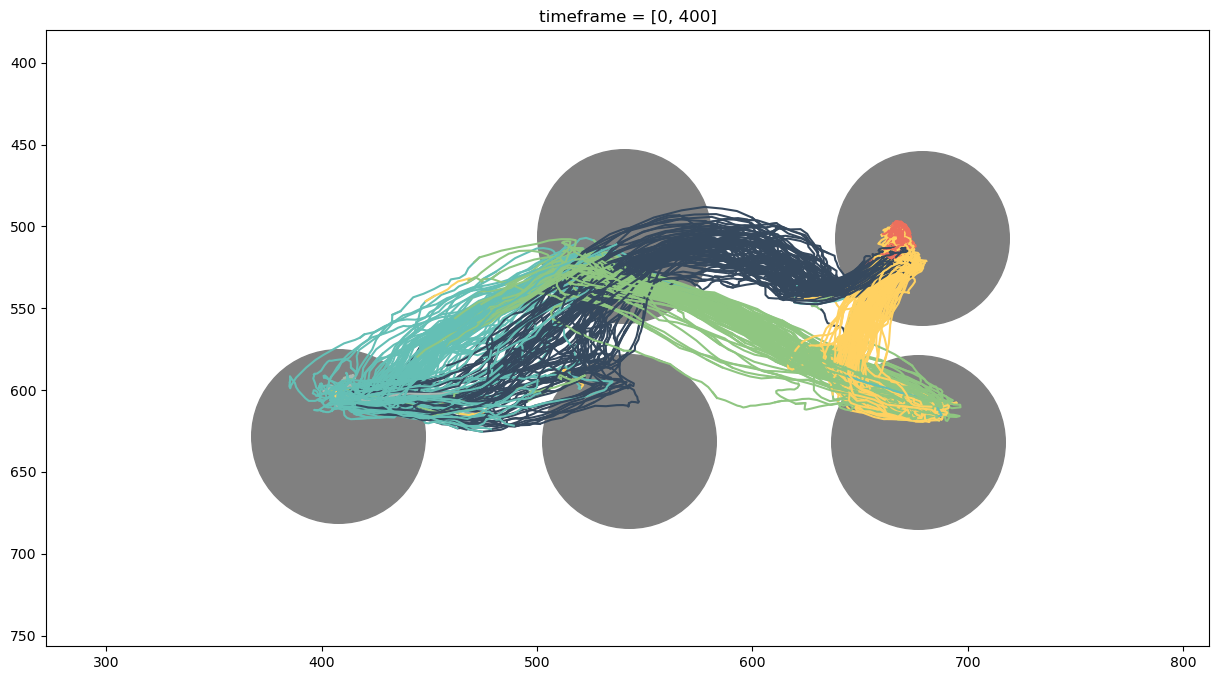

In [8]:
fps = 60
if mouse_session_recording == '148_2_2':
    fps = 40

# behav_mask
mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times - tracking_offset

# Calculate the number of events based on the timeframe size and bin size
events = np.diff(timeframe)[0] /bin_size 
# Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
start_ts = [cam_start_time * fps ]
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * fps

# Create an empty list for end times
end_ts = []
# Loop through the number of events
for i in range(int(events)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        start_ts += [end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    end_ts += [start_ts[i] + bin_ts] 

    
    
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
    for i in range(int(events)):
        ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)

        
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()
    
ax.set_title('timeframe = ' + str(timeframe))

SaveFig('tracking.png',save_path)

# Latent Analysis 


In [38]:
# # change for each animal: 

# color_order = ['red','green','yellow','blue','purple']

# #####

# codes = ['red','blue','purple','green','gold','yellow','darkblue']
# hex_colors = ['#BE575F','#1C79B5','#724F94','#69BD9D','#C6963E','#E2DC92','#264999']
# current_colors =[]
# for each_color in colors[0::]:
#     for i,item in enumerate(hex_colors):
#         if item == each_color:
#             current_colors +=[codes[i]]
# logical_order = [current_colors.index(color) for color in color_order]

# #### SAVE THIS OUT
# logical_order

# np.save(save_path+ 'logical_order.npy', logical_order)

logical_order = np.load(r'Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\178_1_7_run_2701023_1720\analysis_output\latent_composition_analysis\\logical_order.npy')

In [ ]:
#### neighbors vs distant plot,
## fix the plots bellow for now only working with task important seqs 
## save these things out somewhere sensible
## run this for each animal 
## make across animals plots! 

In [ ]:
## change code below so that it only analysses the sequences we care about... 

In [ ]:
### need to have info about the logical order and the number of important sequences... 
# number important I have written down 

In [40]:
def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def calculate_percentages(numbers):
    total = sum(numbers)
    percentages = [(number/total) * 100 for number in numbers]
    return percentages

def calculate_percentages(numbers):
    total = sum(numbers)
    percentages = [(number/total) * 100 for number in numbers]
    return percentages


1
3
4
5
6


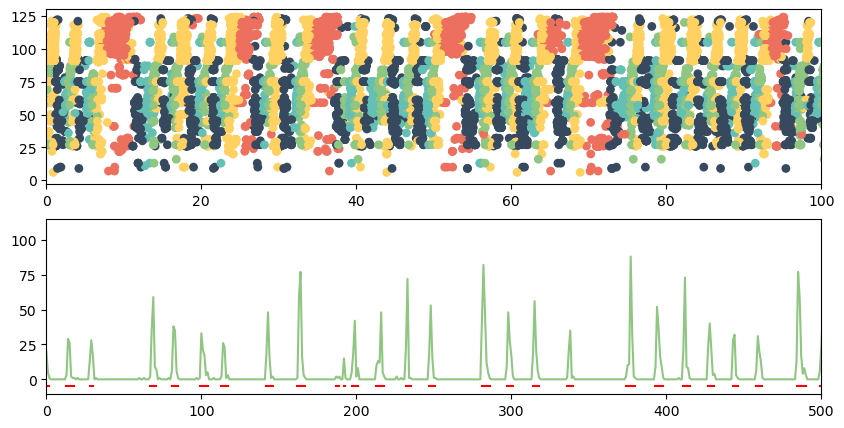

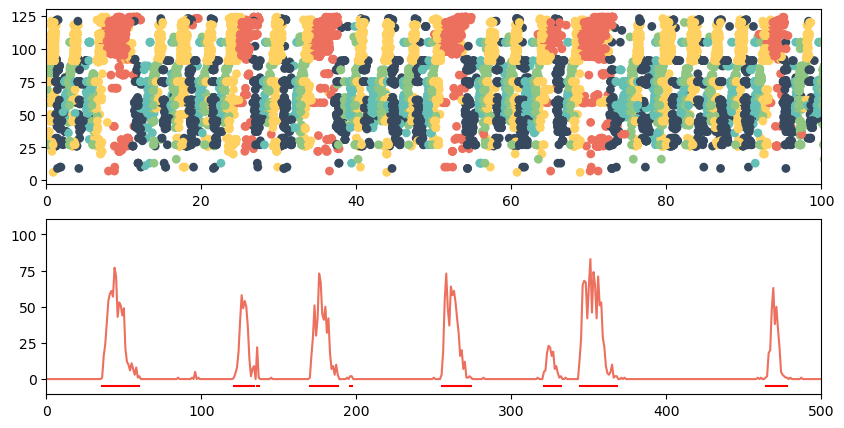

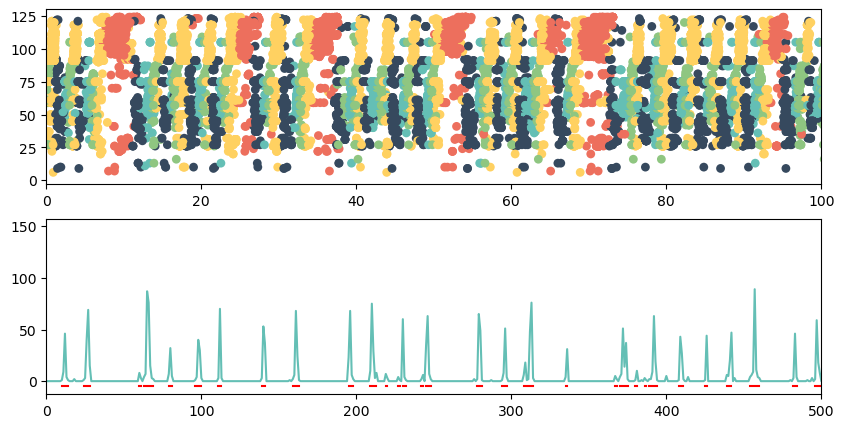

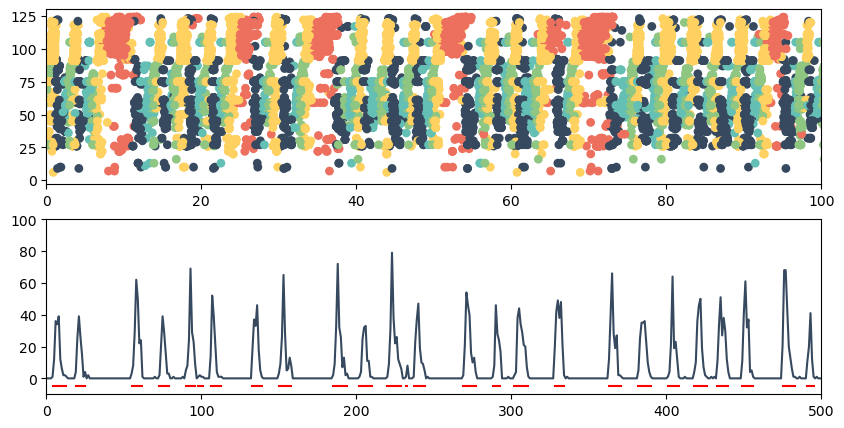

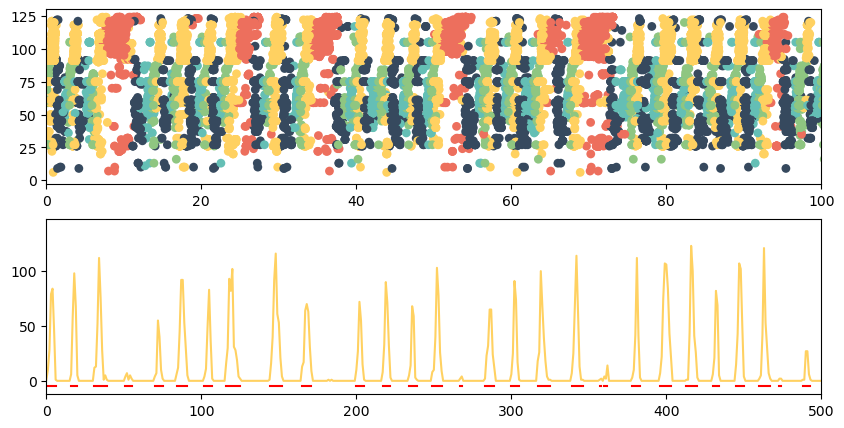

In [41]:
#### first define when seqs occur and label neurons that contribute to them 


seq_size_threshold= 5
    

all_seq_neurons = []  
df_seq_inds = []
total_seqs_by_type =[]
seq_numbers_passed = []
current_order = []
all_mid_point_times = []
for i in range(1,7):
    if i-1 in logical_order:
        print(i)
        
        seq_spike_count = seq_spike_occurance[i]
        # find seq start and end, defined by whetehr there were spikes or not 
        groups = return_inds_for_seq_groups(seq_spike_count)

        ### plot to check that I am accounting ofr sequences properly

        #mask
        # spikemask
        timeframe = [0,800]
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]

        fig,[ax1,ax2] = plt.subplots(2, 1,figsize=(10, 5))
        ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
        ax2.plot(seq_spike_count, color = colors[i])
        for item in groups:
            ax2.plot(item,[-5,-5], color = 'red')


        ax1.set_xlim([0,100])
        ax2.set_xlim([0,(100/bin_size)])

        seq_neurons = []
        df_index = []
        mid_point_time = []

        counter = 0
        for group in groups:

            # spikemask
            timeframe = [(group[0] * bin_size)-0.5,(group[-1] * bin_size)+0.5]
            mid_point_time += [timeframe[0] + (np.diff(timeframe)[0]/2)]
            mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
            seq_mask = unmasked_spikes_df[mask].sequence_type_adjusted == i

            if len(unmasked_spikes_df[mask][seq_mask]) > seq_size_threshold:
                counter +=1
                seq_neurons.append(list(unmasked_spikes_df[mask][seq_mask].neuron))
                df_index += [list(unmasked_spikes_df[mask][seq_mask].index)]

        total_seqs_by_type += [counter]
        all_seq_neurons.append(seq_neurons)
        df_seq_inds.append(df_index)
        all_mid_point_times += [mid_point_time]
        
        current_order +=[i]

    
    

In [42]:
#### determine how often each neuron appears in each sequence
    
neuron_ids = []
appearance_breakdown = []
for neuron in unmasked_spikes_df.neuron.unique():
    seqs_appeared = []
    for index,seq_number in enumerate(current_order):
        counter = 0
        for event in all_seq_neurons[index]:
            if event.count(neuron) > 0:
                counter +=1
        seqs_appeared +=[counter]
    neuron_ids += [neuron]
    appearance_breakdown += [seqs_appeared]
    
    

In [43]:
threshold= 10
dominance = []
total_seqs = []
dominant_seq = []
p_appearence = []
no_preference = 0
for index,item in enumerate(appearance_breakdown):
    item_proportion = (np.array(item)/total_seqs_by_type)*100
    if sum(item_proportion) > threshold:
        dominance += [max(item_proportion)/sum(item_proportion)]
        dominant_seq += []
        max_index = list(item_proportion).index(max(item_proportion))
        dominant_seq += [max_index]
        p_appearence += [item[max_index]/total_seqs_by_type[max_index]]
    else:
        no_preference +=1

    all_seqs = item_proportion[item_proportion > threshold] 
    total_seqs.append(len(all_seqs))
        

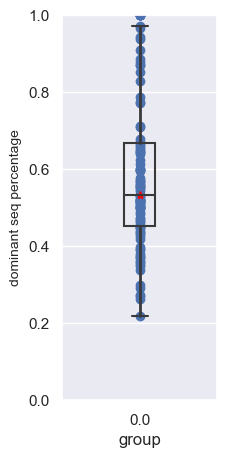

In [44]:
## for the dominant seq eahc neuron appears in, how dominant is it? 

import seaborn as sns; sns.set()
fig,ax= plt.subplots(1, 1,figsize=(2, 5))
dark_blue = '#264999'

ax.plot(np.zeros(len(dominance)),dominance,'o')
ax.plot(0,np.median(dominance),'*', color = 'red')
ax.set_ylim(0,1)

plot_df = pd.DataFrame({'group': np.zeros(len(dominance)), 'doinant_percentage': dominance})

ax=sns.boxplot( y = 'doinant_percentage', x = 'group', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_ylabel('dominant seq percentage',size = 10)


SaveFig('dominant_relative_percentage.png',save_path)
np.save(save_path+ 'dominance.npy', dominance)


In [45]:
np.median(dominance)

0.5335873989967931

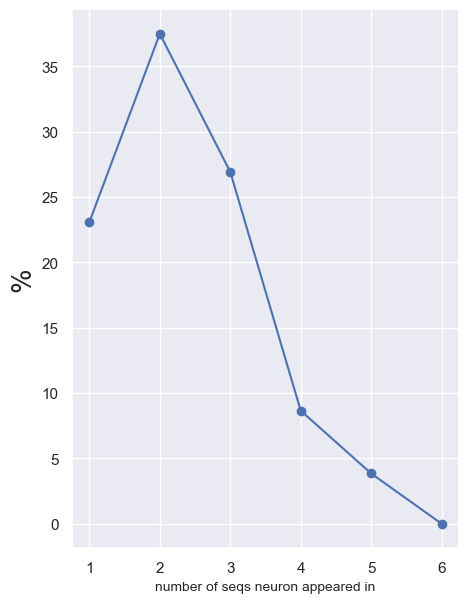

In [46]:
# plot number of sequences neurons appear in as percentage of spikes

counts = []
for i in range(1,7):
    counts.append(total_seqs.count(i))
counts= calculate_percentages(counts)

fig,ax= plt.subplots(1, 1,figsize=(5, 7))

ax.plot([1,2,3,4,5,6],counts,'o-')
# color labels by motif/seq colour


    
ax.set_ylabel('%',size = 20)
ax.set_xlabel('number of seqs neuron appeared in',size = 10)

SaveFig('seqs_appeared_in.png',save_path)
np.save(save_path+ 'Num_seqs_neurons_appeared_in.npy', counts)


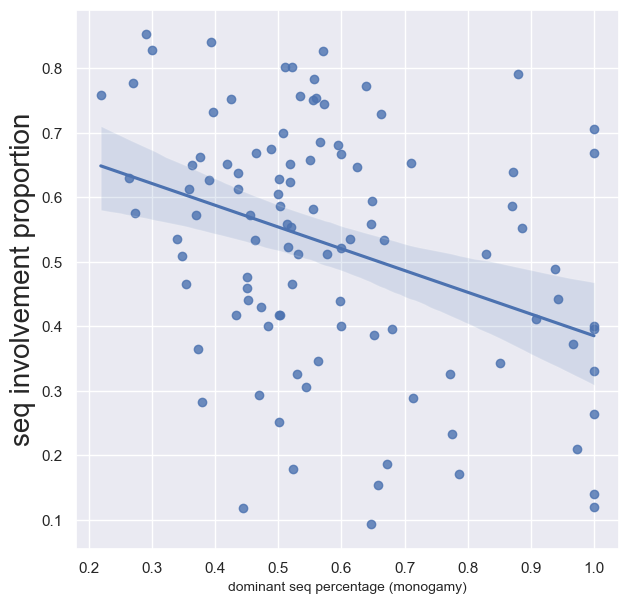

In [47]:
# p_appearence = []
# # loop across dominant seqs 
# for index,dseq in enumerate(dominant_seq):
#     #loop across all instances of that seq
#     appeared = []
#     for event in all_seq_neurons[dseq-1]:
#         current_neuron = neuron_id[index]
#         if event.count(current_neuron) > 0:
#             appeared.append(1)
#         else:
#             appeared.append(0)
#     p_appearence.append(sum(appeared)/len(appeared))

# p_appearence= []
# for item in appearance_breakdown:
#         max_index = list(item_proportion).index(max(item_proportion))



#plot dominant sequence dominance (percentage) vs how often a neuron actually spikes in a sequence. 

fig,ax= plt.subplots(1, 1,figsize=(7, 7))
sns.regplot(y=p_appearence, x=dominance, ax = ax)
ax.set_ylabel('seq involvement proportion',size = 20)
ax.set_xlabel('dominant seq percentage (monogamy)',size = 10)

SaveFig('dominant_percentage_vs_seq_involvement_prop.png',save_path)
np.save(save_path+ 'seq_involvement_prop.npy', p_appearence)

C:\Users\Emmett\AppData\Local\Temp\ipykernel_25368\3904176648.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sorted_pas = np.array(P_apprearance_breakdown_per_neuron_sorted)[logical_order_as_asending_values]


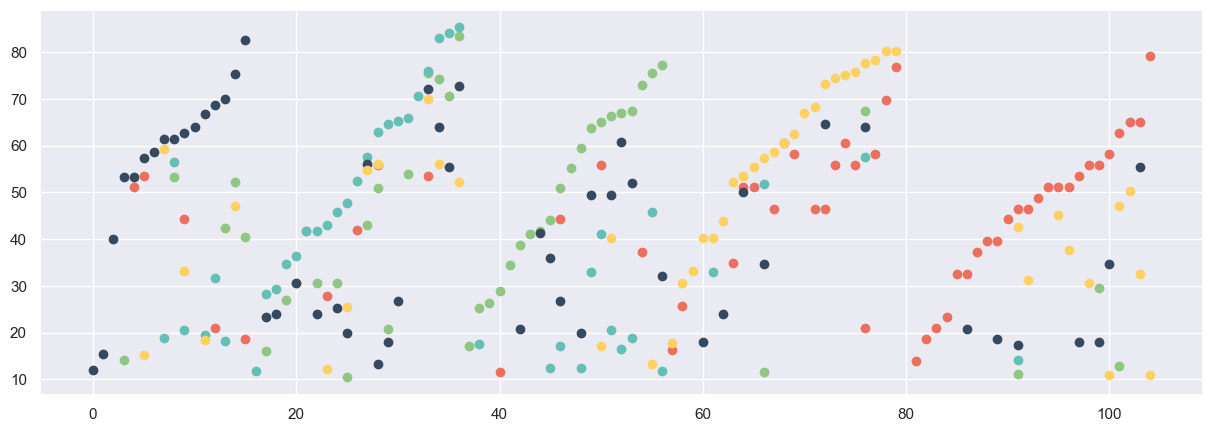

In [48]:
# for each neuron plot the filtered proportion occurance,in each seq, and order them by sequence and by involvement.  

P_apprearance_breakdown_per_neuron = []
for index,item in enumerate(appearance_breakdown):
    item_proportion = (np.array(item)/total_seqs_by_type)*100
    if sum(item_proportion) > threshold:
        P_apprearance_breakdown_per_neuron += [item_proportion]

## order by dominant (for sorting)
P_apprearance_breakdown_per_neuron = np.array(P_apprearance_breakdown_per_neuron)[np.argsort(dominant_seq)]

new_ordering = np.array(dominant_seq)[np.argsort(dominant_seq)]
   
# sot by proportion appeared in dominant
P_apprearance_breakdown_per_neuron_sorted = []
for seq_type in range(len(current_order)):
    array_of_arrays = P_apprearance_breakdown_per_neuron[new_ordering == seq_type]

    # Find the largest number in each array and select only these arrays
    largest_numbers = [max(subarray) for subarray in array_of_arrays]

    # Sort the array of arrays based on the largest numbers
    sorted_array_of_arrays = array_of_arrays[np.argsort(largest_numbers)]

    P_apprearance_breakdown_per_neuron_sorted += [list(sorted_array_of_arrays)]

    
# turn logical order in value asending order so it can be applieed. 
# Create a mapping dictionary
mapping = {value: index for index, value in enumerate(sorted(logical_order))}
# Generate the new list using the mapping
logical_order_as_asending_values = [mapping[value] for value in logical_order]


sorted_pas = np.array(P_apprearance_breakdown_per_neuron_sorted)[logical_order_as_asending_values]
flattened_pas = [item for sublist in sorted_pas for item in sublist]
    
    
fig, ax = plt.subplots(1, 1,figsize=(15, 5))

for index,item in enumerate(flattened_pas):
    for i in range(len(item)):
        if item[i] > 10:
            ax.plot(index,item[i],'o',color = colors[np.array(current_order)[i]])
            
# SaveFig('proporiton_seq_occurance.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')
np.save(save_path+ 'proporiton_seq_occurance.npy', flattened_pas)

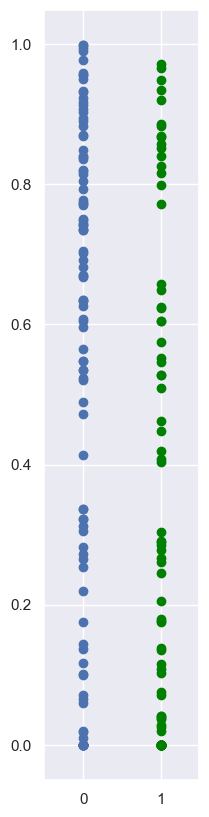

In [49]:
### make this relative proportions! 
if len(logical_order) > 3:
    neighbor_proportions = []
    non_neighbor_proportions = []
    for index,appearance_seq in enumerate(P_apprearance_breakdown_per_neuron_sorted):
        neighbor1 = index - 1
        neighbor2 = index + 1
        if neighbor1 == -1:
            neighbor1 = np.unique(new_ordering)[-1]
        if neighbor2 == np.unique(new_ordering)[-1] + 1:
            neighbor2 = 0  

        non_neighbor_seqs = list(np.unique(new_ordering))
        non_neighbor_seqs.remove(index)
        non_neighbor_seqs.remove(neighbor1)
        non_neighbor_seqs.remove(neighbor2)

        for appearance_breakdown in appearance_seq:
        #         neighbor_proportions += [appearance_breakdown[neighbor1]/ appearance_breakdown[index]]
        #         neighbor_proportions += [appearance_breakdown[neighbor2]/ appearance_breakdown[index]]
            if len((appearance_breakdown[neighbor1]/ appearance_breakdown[index],appearance_breakdown[neighbor2]/ appearance_breakdown[index])) > 0:
                neighbor_proportions += [max(appearance_breakdown[neighbor1]/ appearance_breakdown[index],appearance_breakdown[neighbor2]/ appearance_breakdown[index])]
            if len((appearance_breakdown[non_neighbor_seqs]/ appearance_breakdown[index])) > 0:
                non_neighbor_proportions += [max(appearance_breakdown[non_neighbor_seqs]/ appearance_breakdown[index])]

    fig, ax = plt.subplots(1, 1,figsize=(2, 10))

    ax.plot(np.zeros(len(non_neighbor_proportions)),non_neighbor_proportions,'o')
    ax.plot(np.ones(len(neighbor_proportions)),neighbor_proportions,'o',c ='green')
    ax.set_xlim(-0.5,1.5)

    SaveFig('non_neighbors_and_neightbors_relative_occurance.png',save_path)
    np.save(save_path+ 'non_neighbor_proportions.npy', non_neighbor_proportions)
    np.save(save_path+ 'neighbor_proportions.npy', neighbor_proportions)

In [50]:
### for each dominant sequence. plot the proportion of time it appears in a neighboring seq vs a non neighboring seq. Or plot distance vs appearance. 


In [51]:
## determine number of sequences each neuron appears in 
neuron_id = []
percentage_breakdown = []
dominant_percentage = []
seqs_unique = []
dominant_seq = []
# loop across neurons 
for neuron_ in unmasked_spikes_df.neuron.unique():
    
    current_neuron_mask = unmasked_spikes_df.neuron == neuron_
    seq_type_appearances = unmasked_spikes_df[current_neuron_mask].sequence_type_adjusted.values.astype(int)

    #n percentage spikes that are background:
    len(seq_type_appearances[seq_type_appearances < 0])/len(seq_type_appearances)
    
    #percentage split across 
    background_remove = seq_type_appearances > 0
    seq_type_appearances[background_remove]

    seq_appearnce= []
    count = []
    
    # if not background:
    if not len(seq_type_appearances[background_remove]) == 0:     
        
        seqs_unique.append(list(np.unique(seq_type_appearances[background_remove])))
        for seq in np.unique(seq_type_appearances[background_remove]):
            seq_appearnce.append(seq)
            count.append(list(seq_type_appearances[background_remove]).count(seq))

        percentage_breakdown.append(calculate_percentages(count))
        dominant_percentage.append(max(calculate_percentages(count)))
        dominant_seq.append(np.unique(seq_type_appearances[background_remove])[np.argmax(calculate_percentages(count))])
        neuron_id.append(neuron_)

In [52]:
import scipy 
N_neurons= bkgd_log_proportions_array.shape[1]


# Iterate through the range
concat_data_rp = []
concat_data_o = []
for neuron in tqdm(range(N_neurons)):
    
    resp_prob_1 = []
    resp_prob_2 = []
    resp_prob_3 = []
    resp_prob_4 = []
    resp_prob_5 = []
    resp_prob_6 = []
    
    offset_1 = []
    offset_2 = []
    offset_3 = []
    offset_4 = []
    offset_5 = []
    offset_6 = []

    for iteration_ in range(400, 500):
        index_ = neuron + (N_neurons *  iteration_)
        current_data = neuron_response_df.loc[neuron_response_df.index == index_]
        resp_prob_1 += [float(current_data.x1)]
        resp_prob_2 += [float(current_data.x2)]
        resp_prob_3 += [float(current_data.x3)]
        resp_prob_4 += [float(current_data.x4)]
        resp_prob_5 += [float(current_data.x5)]
        resp_prob_6 += [float(current_data.x6)]
        
        offset_1 += [current_data.x7]
        offset_2 += [current_data.x8]
        offset_3 += [current_data.x9]
        offset_4 += [current_data.x10]
        offset_5 += [current_data.x11]
        offset_6 += [current_data.x12]
         
    new_row = [neuron+1,resp_prob_1,resp_prob_2,resp_prob_3,resp_prob_4,resp_prob_5,resp_prob_6]
    concat_data_rp.append(new_row)
    
    new_row = [neuron+1,offset_1,offset_2,offset_3,offset_4,offset_5,offset_6]
    concat_data_o.append(new_row)

resp_prop_df = pd.DataFrame(concat_data_rp, columns = ['neuron','response_prob_1','response_prob_2','response_prob_3','response_prob_4','response_prob_5','response_prob_6'])
offset_df = pd.DataFrame(concat_data_o, columns = ['neuron','offset_1','offset_2','offset_3','offset_4','offset_5','offset_6'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.88it/s]


In [53]:
def calculate_mean_sem_of_neuron_seq_repsonses(resp_prop_df, var_arg ):

    all_mean_mean_resp_prop = []
    all_sem_mean_resp_prop = []
    all_index =[]

    for i_ in range(len(resp_prop_df)):
        row = resp_prop_df.loc[resp_prop_df.index == i_]

        mean_mean_resp_prop = []
        sem_mean_resp_prop = []
        for item in list(row)[1::]:
            if not var_arg == 'offset':
                resp_prop_unlog = np.exp(list(row[item])[0])
            else:
                resp_prop_unlog = list(row[item])[0]
            mean_mean_resp_prop += [np.mean(resp_prop_unlog)]
            if var_arg == 'offset':
                sem_mean_resp_prop += [scipy.stats.sem(resp_prop_unlog)[0]]
            else:
                sem_mean_resp_prop += [scipy.stats.sem(resp_prop_unlog)]

        all_mean_mean_resp_prop += [mean_mean_resp_prop]
        all_sem_mean_resp_prop += [sem_mean_resp_prop]
        all_index+=[i_]*len(mean_mean_resp_prop)

    return all_mean_mean_resp_prop,all_sem_mean_resp_prop,all_index

def calculate_mean_std_of_neuron_seq_repsonses(resp_prop_df, var_arg ):

    all_mean_mean_resp_prop = []
    all_sem_mean_resp_prop = []
    all_index =[]

    for i_ in range(len(resp_prop_df)):
        row = resp_prop_df.loc[resp_prop_df.index == i_]

        mean_mean_resp_prop = []
        sem_mean_resp_prop = []
        for item in list(row)[1::]:
            if not var_arg == 'offset':
                resp_prop_unlog = np.exp(list(row[item])[0])
            else:
                resp_prop_unlog = list(row[item])[0]
            mean_mean_resp_prop += [np.mean(resp_prop_unlog)]
            if var_arg == 'offset':
                sem_mean_resp_prop += [np.std(resp_prop_unlog)[0]]
            else:
                sem_mean_resp_prop += [np.std(resp_prop_unlog)]

        all_mean_mean_resp_prop += [mean_mean_resp_prop]
        all_sem_mean_resp_prop += [sem_mean_resp_prop]
        all_index+=[i_]*len(mean_mean_resp_prop)

    return all_mean_mean_resp_prop,all_sem_mean_resp_prop,all_index

all_mean_mean_resp_prop,all_std_mean_resp_prop,all_index_rp = calculate_mean_std_of_neuron_seq_repsonses(resp_prop_df,'resp_prop')
all_mean_mean_offset,all_sem_mean_offset,all_index_o = calculate_mean_sem_of_neuron_seq_repsonses(offset_df,'offset')

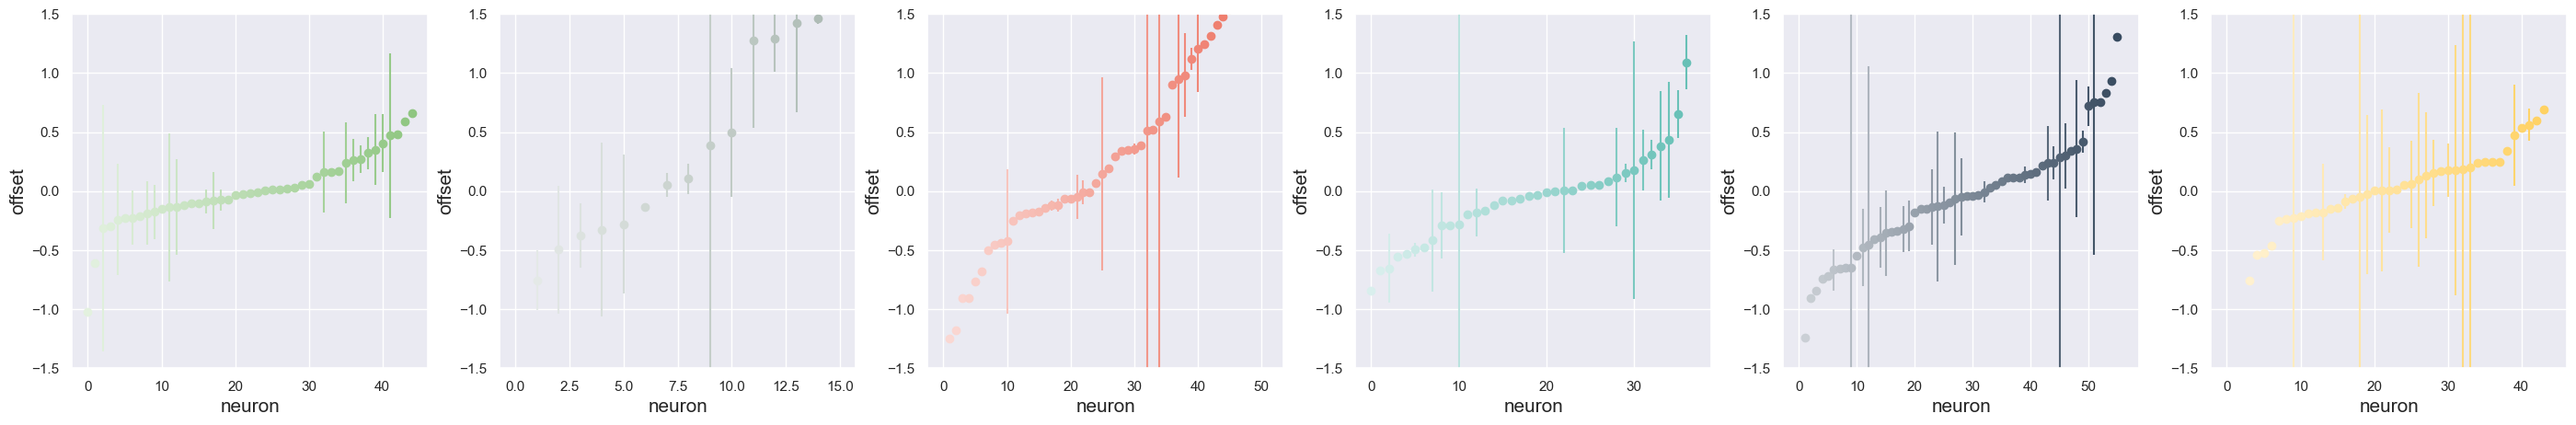

In [54]:
threshold = 10

import matplotlib.colors as mcolors

def create_color_gradient(start_color, end_color, num_samples):
    # Create a linear gradient between start_color and end_color
    gradient = np.linspace(0, 1, num_samples)

    # Create a color map using the start_color and end_color
    color_map = mcolors.LinearSegmentedColormap.from_list(
        'color_gradient', [start_color, end_color]
    )

    # Generate a list of colors from the color map
    colors = [color_map(gradient_value) for gradient_value in gradient]

    return colors

### for neurons that are actually involved in a sequence, what is their offset. ie. split by neurons that contribute at all (or at least over a threshold) to the seq - not just dominant ones 

nrow = 1 
ncol = 6
fig, axs = plt.subplots(nrow, ncol,figsize=(35, 5))

tot = 0
for index, ax in enumerate(fig.axes):
    seq = index + 1
    neuron_include  = []
    for index,neuron_seqs in enumerate(seqs_unique):
        if seq in neuron_seqs:
            p_occurance = percentage_breakdown[index][np.where(np.array(neuron_seqs) == seq)[0][0]]
            if p_occurance > threshold:
                neuron_include.append(index)
                
    offsets = np.array(all_mean_mean_offset)[np.array(neuron_include)][:,seq-1]
    e_bars = np.array(all_sem_mean_offset)[np.array(neuron_include)][:,seq-1]
#     ax.plot(sorted(offsets),'o', c = colors[seq])

    x = list(range(0,len(offsets)))
    y = sorted(offsets)
    
    tot+=len(x)
    
    color_gradient = create_color_gradient('white', colors[seq], len(x))
    intermediate_color = color_gradient[int(len(color_gradient) *0.25)]
    color_gradient = create_color_gradient(intermediate_color, colors[seq], len(x))
    
    for i in range(len(x)):
        ax.errorbar(x[i],y[i], yerr=e_bars[i], fmt='o', c = color_gradient[i])
    ax.set_ylim((-1.5,1.5))
    
    ax.set_ylabel('offset',size = 15)
    ax.set_xlabel('neuron',size = 15)
    
SaveFig('temporal_order.png',save_path)


In [27]:
### order these by average distance between motifs? 
###### determine gaps between each:
def find_sequence(long_sequence, short_sequence):
    long_length = len(long_sequence)
    short_length = len(short_sequence)  
    occurrences = []
    for i in range(long_length - short_length + 1):
        if long_sequence[i:i+short_length] == short_sequence:
            occurrences.append(i)
    return occurrences

threshold = 2 #seconds

combined_events = []
seq_type_labels = []
for index,events in enumerate(all_mid_point_times):
    combined_events += events
    seq_type_labels += [np.array(sorted(logical_order))[index]]*len(events)
    
sorted_events = list(np.array(combined_events)[np.argsort(combined_events)])
sorted_labels = list(np.array(seq_type_labels)[np.argsort(combined_events)])

all_gaps = []
for e in range(len(logical_order)-1):
    print(e)
    occurance_inds = find_sequence(sorted_labels,[logical_order[e],logical_order[e+1]])

    gap = []
    for i in range(len(occurance_inds)):
        current_gap = np.diff(sorted_events[occurance_inds[i]:occurance_inds[i]+2])[0]
        if current_gap < threshold:
            gap += [current_gap]
    all_gaps += [gap]
    
gap_means = []
for gap in all_gaps:
    gap_means += [np.mean(gap)]

0
1
2
3
4


111
111
111
111
111


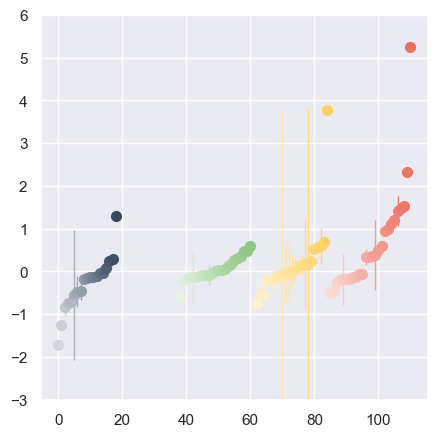

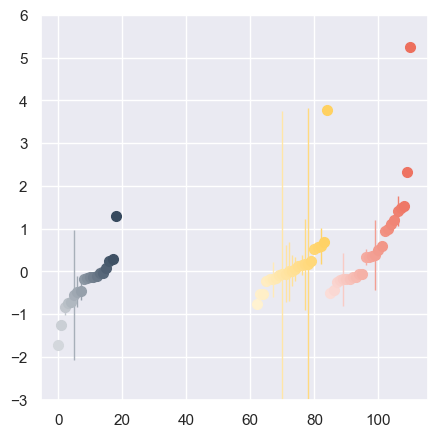

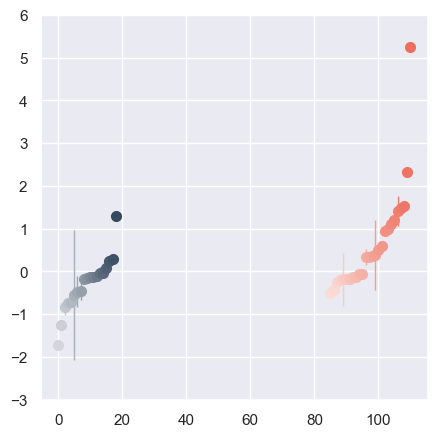

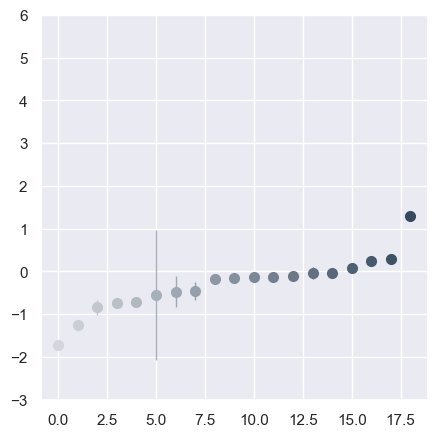

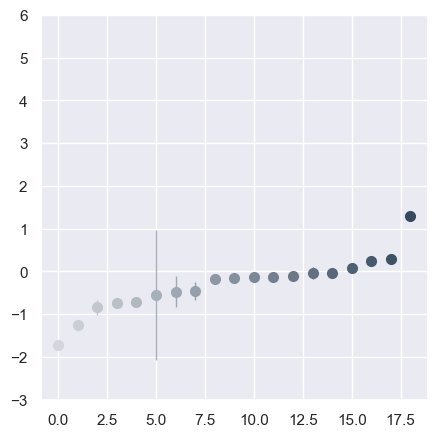

In [72]:


all_offsets = []
all_colors = []
all_e_bars = []

for index in range(6):
    seq = index + 1
    neuron_include  = []
    for index,neuron_seqs in enumerate(seqs_unique):
        if seq in neuron_seqs:
            p_occurance = percentage_breakdown[index][np.where(np.array(neuron_seqs) == seq)[0][0]]
            if p_occurance > threshold:
                current_neuron = neuron_id[index]
                if current_neuron in list(np.array(neuron_id)[np.array(dominant_seq) == seq]):
                    neuron_include.append(index)
                
    offsets = np.array(all_mean_mean_offset)[np.array(neuron_include)][:,seq-1]
    e_bars = np.array(all_sem_mean_offset)[np.array(neuron_include)][:,seq-1]
#     ax.plot(sorted(offsets),'o', c = colors[seq])

    x = list(range(0,len(offsets)))
    y = sorted(offsets)
    
    color_gradient = create_color_gradient('white', colors[seq], len(x))
    intermediate_color = color_gradient[int(len(color_gradient) *0.25)]
    color_gradient = create_color_gradient(intermediate_color, colors[seq], len(x))
    
    all_offsets+=[y]
    all_colors+=[color_gradient]
    all_e_bars += [e_bars]
    
def reorder_lists(original_list, index_list):
    return [original_list[i] for i in index_list]

def add_missing_numbers(lst, start_num, end_num):
    new_lst = lst.copy()
    missing_numbers = [num for num in range(start_num, end_num+1) if num not in lst]
    new_lst += missing_numbers
    return new_lst,len(missing_numbers)



new_order, missing_count = add_missing_numbers(logical_order, 0, 5)

new_order = np.array([4, 3, 0, 5, 2,1])

reordered_all_offsets = reorder_lists(all_offsets,new_order)
reordered_all_e_bars = reorder_lists(all_e_bars,new_order)
reordered_all_all_colors = reorder_lists(all_colors,new_order)

## add in gaps
for i in range(len(np.cumsum(gap_means))):
    reordered_all_offsets[i+1] = list(np.array(reordered_all_offsets[i+1]) + np.cumsum(gap_means)[i])

    flat_offsets = [item for sublist in reordered_all_offsets[0:-missing_count] for item in sublist]
    flat_e_bars = [item for sublist in reordered_all_e_bars[0:-missing_count] for item in sublist]
    flat_colors_grads = [item for sublist in reordered_all_all_colors[0:-missing_count] for item in sublist]
    x = np.linspace(0 ,len(flat_offsets)-1,len(flat_offsets))
    
    print(len(x))



    fig, ax = plt.subplots(1, 1,figsize=(5, 5))
    for i,y in enumerate(flat_offsets):
        ax.errorbar(x[i],y, yerr=flat_e_bars[i], fmt='o', c = flat_colors_grads[i],markersize = 7, linewidth = 1)
    ax.set_ylim(-3,6)

# SaveFig('temporal_order_ordered.png',save_path)
# SaveFig('temporal_order_ordered.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')


# Across animals

In [14]:
# loop over all animals and load in data 

# dominance 
# plot average dominance per animal? 

# num of seqs appeared in 
# plot all data ontop of each other 

# dominance vs seq occurance 

# neighbor plot 


In [15]:
PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
## set ppseq file
dominance_a_a = []
Num_seqs_neurons_appeared_in_a_a = []
seq_involvement_prop_a_a = []
non_neighbor_proportions_a_a = []
neighbor_proportions_a_a = []

for file_ in os.listdir(PP_PATH):
    if 'run' in file_:
        current_path = PP_PATH + file_ + r"\analysis_output\\latent_composition_analysis\\"
        if os.path.isdir(current_path):
            dominance_a_a += [list(np.load(current_path + 'dominance.npy'))] 
            print(file_)
            Num_seqs_neurons_appeared_in_a_a += [list(np.load(current_path + 'Num_seqs_neurons_appeared_in.npy'))] 
            seq_involvement_prop_a_a += list(np.load(current_path + 'seq_involvement_prop.npy'))
            try:
                non_neighbor_proportions_a_a += [list(np.load(current_path + 'non_neighbor_proportions.npy'))]  
                neighbor_proportions_a_a += [list(np.load(current_path + 'neighbor_proportions.npy'))]
            except:
                print('no neighbours ' + file_)

    
    

#         file = file_
# save_path = save_path + 'latent_composition_analysis\\'

136_1_3_run_2701023_1835
136_1_4_run_2701023_1813
148_2_2_run_2701023_1717
149_1_1_run_2701023_2100
149_1_2_run_2701023_1856
162_1_3_run_2701023_2241
178_1_4_run_2701023_2020
178_1_5_run_2701023_1657
178_1_6_run_2701023_1750
178_1_7_run_2701023_1720
178_1_8_run_2701023_1641
178_1_9_run_2701023_1748
178_2_1_run_2701023_2006
178_2_2_run_2701023_1728
178_2_3_run_2701023_1532
178_2_4_run_0102023_0016
268_1_10_run_0606023_0235
no neighbours 268_1_10_run_0606023_0235
269_1_7_run_0606023_0216
270_1_5_run_0606023_0208


In [24]:
len(os.listdir(PP_PATH))

45

In [23]:
len(PP_PATH)

86

NameError: name 'sns' is not defined

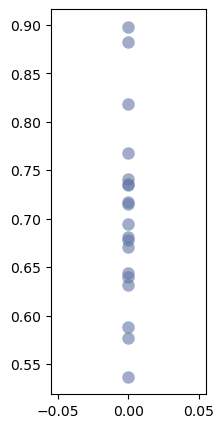

In [18]:

### doniman proportion 

fig,ax= plt.subplots(1, 1,figsize=(2, 5))
means = []
for list_doms in dominance_a_a:
    means += [np.mean(list_doms)]
ax.plot(np.zeros(len(means)),means,'o',color = '#6275A5', markersize = 9,alpha = 0.6, markeredgewidth=0.0)

plot_df = pd.DataFrame({'group': np.zeros(len(means)), 'doinant_percentage': means}, )

ax=sns.boxplot( y = 'doinant_percentage', x = 'group', data = plot_df, color = '#6275A5', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
ax.set_ylim(0,1)

SaveFig('dominance.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')

In [ ]:
np.mean(means)

In [20]:
conactinate_nth_items(Num_seqs_neurons_appeared_in_a_a)

[[37.86407766990291,
  25.24271844660194,
  31.506849315068493,
  46.391752577319586,
  35.483870967741936,
  55.714285714285715,
  21.100917431192663,
  21.49532710280374,
  30.64516129032258,
  23.076923076923077,
  36.470588235294116,
  20.0,
  58.333333333333336,
  30.0,
  50.588235294117645,
  48.64864864864865,
  61.29032258064516,
  31.914893617021278,
  75.0],
 [54.36893203883495,
  47.57281553398058,
  39.26940639269406,
  35.56701030927835,
  41.935483870967744,
  34.285714285714285,
  27.522935779816514,
  54.20560747663551,
  30.64516129032258,
  37.5,
  42.35294117647059,
  24.347826086956523,
  39.166666666666664,
  33.0,
  31.76470588235294,
  32.432432432432435,
  35.483870967741936,
  51.06382978723404,
  22.727272727272727],
 [6.796116504854369,
  22.330097087378643,
  27.85388127853881,
  17.525773195876287,
  20.967741935483872,
  9.285714285714286,
  42.201834862385326,
  20.5607476635514,
  26.61290322580645,
  26.923076923076923,
  15.294117647058824,
  27.826086

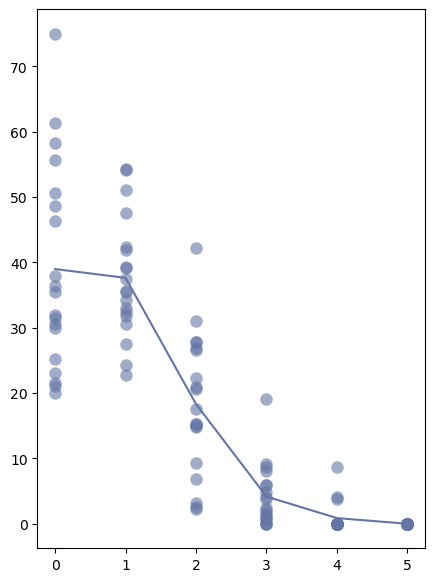

In [19]:
### turn this into a mean for each one and an average line

# plot number of sequences neurons appear in as percentage of spikes
means = []
fig,ax= plt.subplots(1, 1,figsize=(5, 7))
for index,item in enumerate(conactinate_nth_items(Num_seqs_neurons_appeared_in_a_a)):
    ax.plot([index]*len(item),item,'o', color = '#6275A5', markersize = 9,alpha = 0.6, markeredgewidth=0.0)#
    means += [np.mean(item)]
ax.plot(means,'-', color = '#6275A5')


# for counts in Num_seqs_neurons_appeared_in_a_a:

#     ax.plot([1,2,3,4,5,6],counts,'o-')
#     # color labels by motif/seq colour


SaveFig('seqs_per_neuron.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')

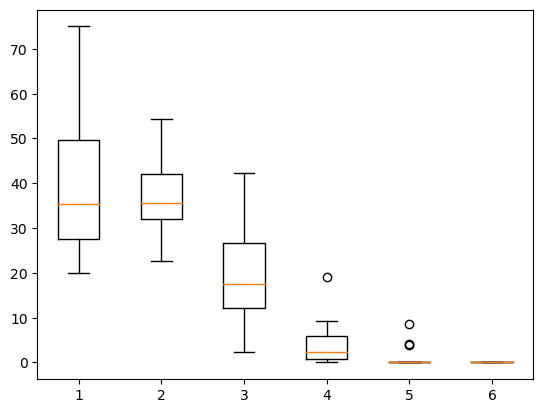

In [22]:
plt.boxplot(conactinate_nth_items(Num_seqs_neurons_appeared_in_a_a))
SaveFig('boxes.pdf',r'D:\\')

In [26]:
len(conactinate_nth_items(Num_seqs_neurons_appeared_in_a_a)[0])

19

In [ ]:
# dominance vs seq occurance 
flat_dominance = [item for sublist in dominance_a_a for item in sublist]

fig,ax= plt.subplots(1, 1,figsize=(7, 7))

# Set scatter point size, line color, and remove marker lines
scatter_kws = {"s": 70, "color": "#6275A5", "edgecolor": "none",'alpha':0.4}

sns.regplot(y=seq_involvement_prop_a_a, x=flat_dominance, ax = ax,scatter_kws=scatter_kws)
ax.set_ylabel('seq involvement proportion',size = 20)
ax.set_xlabel('dominant seq percentage (monogamy)',size = 10)

r, p = scipy .stats.pearsonr(flat_dominance, seq_involvement_prop_a_a)

print(p)

ax.text(1.05,1.05,'r_sq =' + str(r) )

SaveFig('seq_involvement_vs_monogamy.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')

In [ ]:
non_neighbor_means = []
neighbor_means = []
for index,item in enumerate(non_neighbor_proportions_a_a):
    non_neighbor_means += [np.mean(item)]
    neighbor_means += [np.mean(neighbor_proportions_a_a[index])]

#remove nan value:
non_neighbor_means =non_neighbor_means[0:12] + non_neighbor_means[13::]
neighbor_means= neighbor_means[0:12] + neighbor_means[13::]

fig,ax= plt.subplots(1, 1,figsize=(4, 10))
ax.plot(np.ones(len(non_neighbor_means)),non_neighbor_means,'o',color = '#6275A5', markersize = 14,alpha = 0.6, markeredgewidth=0.0 )


ax.plot(np.zeros(len(neighbor_means)),neighbor_means,'o',color = '#6275A5', markersize = 14,alpha = 0.6, markeredgewidth=0.0 )

plot_df = pd.DataFrame({'group': (['neighbour']*len(neighbor_means)) + (['non_neighbour']*len(non_neighbor_means)), 'doinant_percentage': neighbor_means+non_neighbor_means})

ax=sns.boxplot( y = 'doinant_percentage', x = 'group', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

print(scipy.stats.normaltest(non_neighbor_means))
print(scipy.stats.normaltest(neighbor_means))
print('both greater than 0.05 = normally distributed, so paired t test used')
print(scipy.stats.ttest_rel(non_neighbor_means, neighbor_means))

SaveFig('neighbor_plot.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')

In [1847]:
neighbor_means

[0.402411996222512,
 0.2795921381138832,
 0.32637518384529923,
 0.2715642229674029,
 0.37455671118417855,
 0.2863761144219104,
 0.4521968276904482,
 0.3303981224895609,
 0.3630461230911025,
 0.25804584300048666,
 0.3614602101552995,
 0.31495647628208884,
 0.28108999526324,
 0.33627502705921797,
 0.3021907373265584,
 0.25621058944370245,
 0.3951386318338864,
 0.12532571170333742]

In [1821]:
neighbor_means

[[0.402411996222512, 0.08311614287401076],
 [0.2795921381138832, 0.3409967346523444],
 [0.32637518384529923, 0.2510807431506755],
 [0.2715642229674029, 0.17352317608467646],
 [0.37455671118417855, 0.1925000014871789],
 [0.2863761144219104, 0.07855828013162712],
 [0.4521968276904482, 0.3364142860926041],
 [0.3303981224895609, 0.30569325780014966],
 [0.3630461230911025, 0.2836161792129276],
 [0.25804584300048666, 0.5199079671605673],
 [0.3614602101552995, 0.16833741898461915],
 [0.31495647628208884, 0.5215795542213391],
 [0.28108999526324, nan],
 [0.33627502705921797, 0.23338996381146787],
 [0.3021907373265584, 0.09236853895105171],
 [0.25621058944370245, 0.17341231109279773],
 [0.3951386318338864, 0.08439045743606723],
 [0.12532571170333742, 0.03703259712221386]]

C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [893]:
from itertools import combinations

# Define the lists of event times
event_lists = [
    [1, 4, 7, 10, 13],
    [2, 5, 8, 11, 14],
    [3, 6, 9, 12, 15],
    [16, 17, 19, 20, 22],
    [18, 21, 23, 25, 27]
]

# Create combinations of events
event_combinations = list(combinations(range(len(all_mid_point_times)), 5))

# Find times when all events happen together within 5 seconds
matching_times = []
for combination in event_combinations:
    for time in event_lists[combination[0]]:
        if all(abs(time - event_lists[i][0]) <= 5 for i in combination[1:]):
            matching_times.append((combination, time))

# Find average relative timings for each event
average_timings = [0] * len(event_lists)
for combination, time in matching_times:
    for i, event_index in enumerate(combination):
        average_timings[event_index] += time - event_lists[event_index][0]

num_matches = len(matching_times)
average_timings = [timing / num_matches for timing in average_timings]

# Print the results
print("Matching times:")
for combination, time in matching_times:
    print(f"Events {combination} occur together at time {time}")

print("\nAverage relative timings:")
for i, timing in enumerate(average_timings):
    print(f"Event {i}: {timing} seconds")


ZeroDivisionError: division by zero

In [895]:
event_combinations

[(0, 1, 2, 3, 4)]

In [894]:
matching_times

[]

In [892]:
event_combinations

[(0, 1, 2, 3, 4)]

C:\Users\Emmett\AppData\Local\Temp\ipykernel_13100\1213346153.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.pivot('x', 'y', 'count')


<Axes: xlabel='y', ylabel='x'>

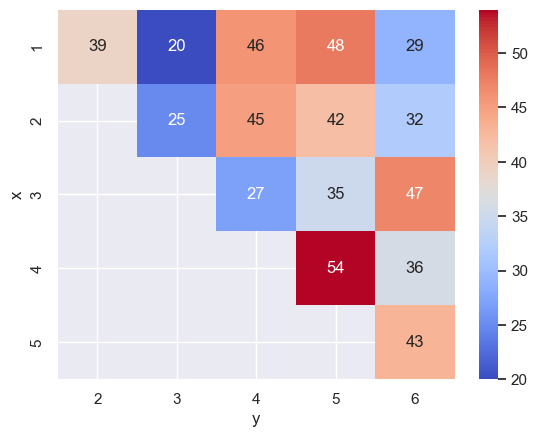

In [266]:
# plot of which seq types corroate wiht each other:

# order is 5416(3)

import seaborn as sns
import pandas as pd


# Create a dictionary to count the number of times each pair of numbers appears together
counts = {}
for lst in seqs_unique:
    for i in range(len(lst)):
        for j in range(i+1, len(lst)):
            pair = (lst[i], lst[j])
            if pair not in counts:
                counts[pair] = 0
            counts[pair] += 1

# Convert the counts dictionary to a Pandas DataFrame
df = pd.DataFrame(list(counts.items()), columns=['pair', 'count'])
df['x'] = df['pair'].apply(lambda x: x[0])
df['y'] = df['pair'].apply(lambda x: x[1])
df = df.pivot('x', 'y', 'count')

# Create a correlation heatmap using Seaborn
sns.heatmap(df, cmap='coolwarm', annot=True)


### change this to make ti more interpretable

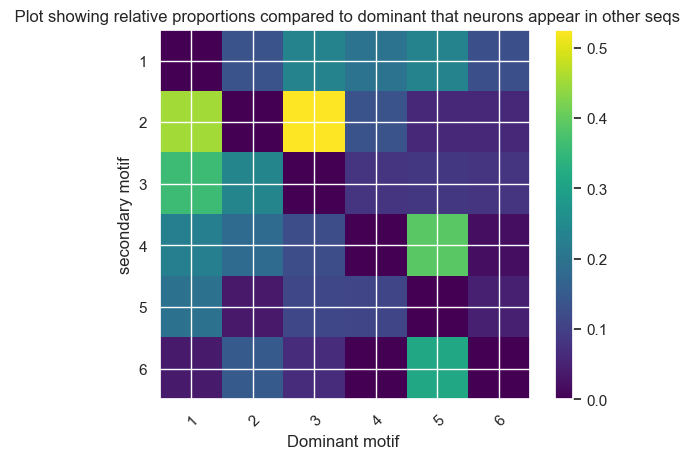

In [384]:
import matplotlib.pyplot as plt
import numpy as np


# Convert the data into a numpy array
data = np.array(reordered_all_seq_relative_props)

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap plot
heatmap = ax.imshow(data, cmap='viridis')

# Add colorbar
cbar = plt.colorbar(heatmap)

# Set the tick labels
ax.set_xticks(np.arange(len(data)))
ax.set_yticks(np.arange(len(data)))

# Set the tick positions
ax.set_xticklabels(np.arange(1, len(data[0]) + 1))
ax.set_yticklabels(np.arange(1, len(data) + 1))

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set the title and labels
ax.set_title(" Plot showing relative proportions compared to dominant that neurons appear in other seqs")
ax.set_xlabel("Dominant motif ")
ax.set_ylabel("secondary motif")

# Show the plot
plt.show()


In [19]:
def hex_format(col):
    return '#{:02X}{:02X}{:02X}'.format(col[0],col[1],col[2])

def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')  # Remove the '#' symbol if present
    hex_len = len(hex_code)
    
    if hex_len == 3:
        # Expand shorthand color codes (e.g., #RGB) to full form (e.g., #RRGGBB)
        hex_code = ''.join(2 * s for s in hex_code)
    
    # Convert each pair of hexadecimal digits to decimal (base 10)
    r, g, b = [int(hex_code[i:i+2], 16) for i in range(0, 6, 2)]
    
    return r, g, b


########## USEFUL: for calculating color change ######

r,g,b = hex_to_rgb(colors[1])
r =
g = 
b =

for i in range(100):
    # Calculate the new color by reducing the amount of red in each iteration
    r = r+1 
    g = g+1
    b = b+1
    # Create the color tuple
    new_color = (r, g, b)
#     print(colors)
    plt.plot(i,1,'o', color = hex_format(new_color))

SyntaxError: invalid syntax (3479967426.py, line 21)

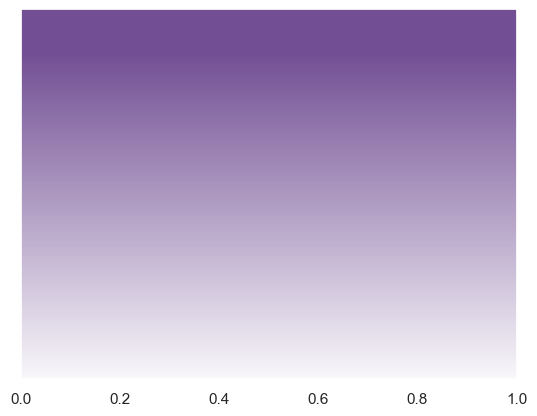

In [214]:
import matplotlib.pyplot as plt
import numpy as np


# Create the color gradient
gradient_colors = create_color_gradient('white', colors[3], 100)

# Display the gradient colors
fig, ax = plt.subplots()
for i, color in enumerate(gradient_colors):
    ax.axhline(i, color=color, linewidth=50)
ax.yaxis.set_visible(False)
plt.show()


In [205]:
r

226

In [206]:
g

220

In [207]:
b

146

In [ ]:
## plot how often neuron appears in each seq all together: so for each neuron its proportiosn for each neuron.
# then group them and arrange by offset? 


In [92]:
#### reorder teh plot above! 

0
1
2
3
4
5


In [137]:
dominant_seq

[6,
 6,
 3,
 5,
 3,
 6,
 5,
 3,
 6,
 3,
 1,
 1,
 6,
 2,
 5,
 3,
 3,
 5,
 1,
 3,
 3,
 3,
 1,
 3,
 6,
 3,
 2,
 6,
 3,
 5,
 3,
 3,
 6,
 3,
 4,
 6,
 3,
 5,
 3,
 3,
 4,
 5,
 3,
 2,
 6,
 3,
 6,
 5,
 6,
 6,
 5,
 4,
 1,
 3,
 4,
 5,
 1,
 4,
 4,
 1,
 1,
 1,
 1,
 5,
 4,
 4,
 1,
 4,
 1,
 1,
 4,
 1,
 4,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 5,
 1,
 4,
 4,
 2,
 5,
 3,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 3,
 3,
 6,
 3,
 6,
 2,
 3,
 4,
 1,
 5,
 4,
 6,
 4,
 4,
 5,
 1,
 5,
 5,
 5,
 6]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6])

array([[0.70555556, 0.15625   , 0.        , 0.10362694, 0.29090909,
        0.        ],
       [0.23888889, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.50555556, 0.        , 0.        , 0.05699482, 0.00606061,
        0.        ],
       [0.37777778, 0.0625    , 0.        , 0.03626943, 0.        ,
        0.        ],
       [0.66111111, 0.03125   , 0.28070175, 0.        , 0.        ,
        0.        ],
       [0.22777778, 0.03125   , 0.        , 0.15544041, 0.06666667,
        0.        ],
       [0.35      , 0.03125   , 0.        , 0.        , 0.18787879,
        0.        ],
       [0.26111111, 0.        , 0.0877193 , 0.        , 0.        ,
        0.        ],
       [0.46111111, 0.03125   , 0.33333333, 0.16062176, 0.24848485,
        0.07058824],
       [0.31111111, 0.        , 0.        , 0.        , 0.05454545,
        0.        ],
       [0.61666667, 0.125     , 0.        , 0.16580311, 0.47272727,
        0.        ],
       [0.4       , 0

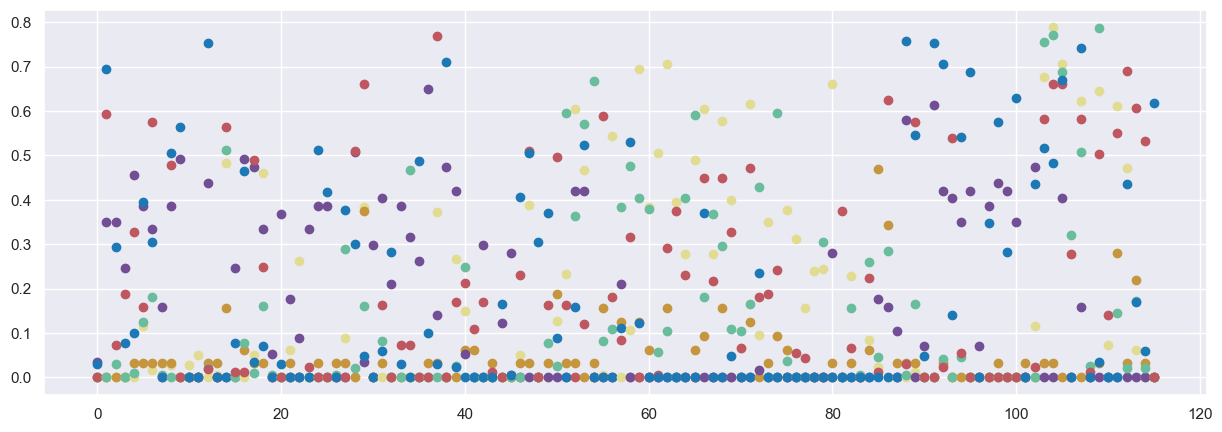

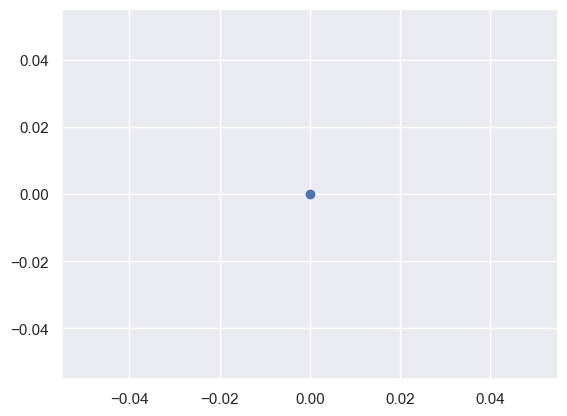

In [104]:
plt.plot(0,item[0],'o')

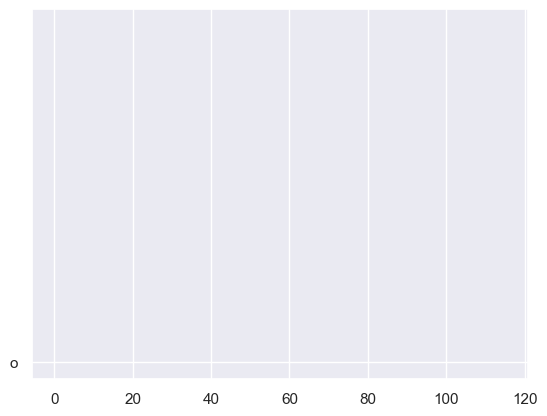

In [97]:
 plt.plot(index,item[i],colors[i+1],'o')

In [98]:
item[i]

0.6176470588235294

In [99]:
index

115

In [396]:
np.array(all_mean_mean_offset)

array([[ 1.42657380e+00, -1.95931733e+00, -4.90447149e-02,
        -3.46355620e+00, -9.50191829e-01,  5.30163327e-02],
       [ 3.32738006e-01,  2.55557922e+00,  1.24877957e+00,
        -4.16600305e-01, -3.36836505e-01,  1.47311552e-02],
       [-2.25197030e-01, -1.38909527e-02, -6.04224852e-02,
        -7.59497291e-01,  5.54961698e-02,  1.97468171e-01],
       [-6.51953507e+00,  7.55855479e-01, -7.66189412e-01,
        -3.68444370e-01,  2.38443721e-01,  3.44566315e-01],
       [-6.54368846e-01, -1.59459324e+00,  1.47950733e+00,
         4.12810170e-02, -6.60210342e-01, -1.43113302e-01],
       [ 8.14748664e-01, -1.99066275e-01,  1.24096871e+00,
         1.76802145e-01,  7.55014843e-01, -6.24305845e-02],
       [-1.62942413e+00, -2.72154777e-01,  1.31363664e+00,
        -2.87423814e-01, -1.32686696e-01, -4.65256286e-01],
       [ 3.44485983e-01, -2.79278039e-01,  1.40887658e+00,
        -4.23275294e-01, -7.37829620e-01, -5.74410518e-01],
       [ 1.22233025e+00, -3.01478815e+00,  6.293

In [378]:
percentage_breakdown

[100.0]

In [ ]:
    percentage_breakdown[index]

In [375]:
percentage_breakdown[index]

[100.0]

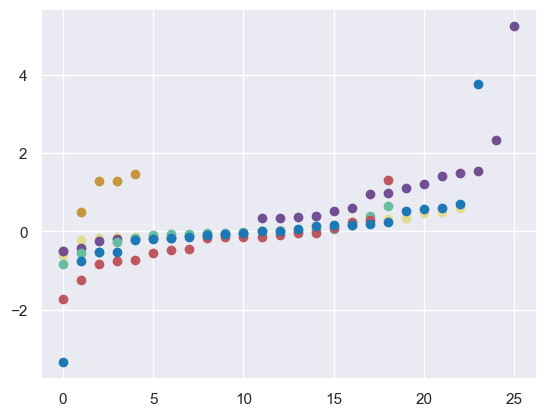

In [370]:

for seq in range(1,7):
    offsets = np.array(all_mean_mean_offset)[np.where(np.array(dominant_seq) == seq)[0]][:,seq-1]
    plt.plot(sorted(offsets),'o', c = colors[seq])

In [358]:
np.array(all_mean_mean_offset)[np.where(np.array(dominant_seq) == 1)[0]]

array([[-1.35576038e-01, -7.44460961e-02, -1.07461179e-02,
        -1.06190871e-01, -4.13662217e-01, -2.19125612e-01],
       [ 2.37785601e-02,  4.27627410e-01, -1.39491852e+00,
        -3.79194850e+00, -9.54901423e-01, -3.27008839e-01],
       [ 3.51099826e-01,  1.20879899e+00,  2.33307310e+00,
        -4.79573851e-01, -1.48668057e-01, -1.32869662e-01],
       [-3.55958910e-02,  8.59653730e-01, -6.76856206e-01,
        -5.25474020e-01,  3.44076809e+00,  3.72290866e+00],
       [ 4.83658363e-01,  3.69122642e-01, -1.00685652e+01,
         2.60926312e-01,  7.59941980e-01,  1.34372723e-01],
       [-2.15833356e-01, -4.44276557e+00,  7.41478178e-01,
        -1.47503192e-01, -2.94210793e-01,  7.54228778e-01],
       [-1.22367149e-01,  4.42312329e+00,  5.63151445e+00,
        -6.53240930e-01,  7.08185931e-01, -3.71937607e-01],
       [-1.06554065e-01,  3.35249309e+00,  2.02852462e+00,
         5.45197954e-02, -2.46234014e-02,  2.74326456e-01],
       [ 5.89646663e-01, -2.04509034e-01,  2.688

In [352]:
np.where(np.array(dominant_seq) == 1)[0]

array([ 10,  11,  18,  22,  52,  56,  59,  60,  61,  62,  66,  68,  69,
        71,  73,  75,  76,  77,  78,  80,  82, 104, 111], dtype=int64)

In [248]:
###### x axis - order neurons by ordering I define when I plot 


142

In [300]:
neuron_permute_loc

array([ 19.,  93.,  59.,  18.,  66.,  74.,  75.,  71.,  69.,  55.,  26.,
         3.,  99.,   0.,  21., 103.,   5.,  56.,  84.,  36.,   1.,  58.,
        77.,  41.,  62., 102.,  46.,  22., 122.,  65.,  80.,  15.,  60.,
        32.,  98.,  57., 120.,  95.,  67.,  87.,   8.,  47.,  52.,  79.,
        76.,  45.,  11.,  20.,  68.,   7.,  91., 105., 100.,  72.,  73.,
       111.,  25.,  48., 117.,  90.,  29.,  10., 119., 118.,  27., 121.,
        34.,  33.,  85., 113., 109.,  70., 115.,  42.,  31.,  24.,  28.,
       124.,  40., 106.,  43.,  37.,  38.,   2.,  23., 123.,  35.,  89.,
       104.,  81., 108.,  78.,  86.,  12.,  54.,  92.,  14.,  61., 101.,
        64.,   4.,  97.,  51.,   6.,  50.,  53.,  49.,  96.,  44.,  13.,
        63., 110.,  30., 114., 107., 116.,  16., 112.,   9.,  17.,  39.,
        88.,  83.,  82.,  94.])

In [282]:
neuron_response_df

x1         x2         x3        x4         x5        x6  \
0     -8.592693  -7.237817  -8.460794 -6.898249 -10.382250 -9.276602   
1     -3.374927  -8.423330  -4.123425 -4.368222  -3.818843 -3.449127   
2     -8.034200  -8.334540  -5.806151 -5.458295  -6.958843 -6.055831   
3     -6.201544  -5.268112  -7.162717 -6.166777  -7.809368 -7.372465   
4     -9.194510  -7.623813  -4.806454 -6.105420  -6.352255 -5.993083   
...         ...        ...        ...       ...        ...       ...   
62495 -2.770151  -2.994643  -8.732548 -4.409251  -3.475882 -9.194577   
62496 -4.331293  -3.706480  -9.617573 -4.357055  -2.730555 -4.570751   
62497 -5.302287  -3.344162 -11.758846 -4.504711  -3.720913 -5.935485   
62498 -8.878267  -4.158775  -9.434139 -4.936076  -4.428847 -5.895618   
62499 -6.843560 -14.411331 -10.094395 -6.744768  -5.728036 -4.452203   

             x7         x8        x9        x10       x11       x12       x13  \
0      1.029052   2.403573 -1.453994  -0.277764 -5.112518  3.057865  0.229158   
1      0.584352  -0.435532 -0.282211   0.393329 -0.491850 -0.168527  0.021418   
2      1.228856  -1.883082  0.479021   1.456811 -0.282920  0.626243  4.874830   
3      0.477052  -5.641198 -0.478913   0.402087  0.708832  0.047151  1.460494   
4     -0.543112   0.516669  2.250030 -12.003169  2.660048  3.966314  0.334988   
...         ...        ...       ...        ...       ...       ...       ...   
62495  0.158145  11.593369 -0.948988  -0.496607 -0.088201 -0.131241  0.039268   
62496 -0.004149   5.745616  1.054531  -0.556468  0.203175 -0.249467  0.011596   
62497  0.180209   5.761189  0.074049  -0.334517  0.292990 -0.202598  0.092781   
62498 -0.272313   4.580330  0.025168  -0.535403  0.224693 -0.092263  0.814904   
62499 -0.826828   1.339485 -0.673080  -0.024577 -0.110613  0.040644  2.532869   

             x14       x15         x16        x17        x18  
0       2.161143  1.104376    0.284392  14.159801   1.985825  
1       0.247610  0.797382    0.071392   0.051343   0.011434  
2       6.533983  0.214400    1.032126   0.043122   0.850861  
3       8.190146  0.264157    2.204596   0.465534   1.667647  
4       0.144186  0.471207  254.214021  28.677812  13.913761  
...          ...       ...         ...        ...        ...  
62495  26.262101  0.745809    0.167667   0.015553   0.185986  
62496   7.142364  0.711849    0.212511   0.051137   0.023191  
62497  45.534385  0.485304    0.237386   0.061513   0.017719  
62498  62.265251  0.366972    0.174699   0.025910   0.017296  
62499   2.820183  0.469339    0.114838   0.065747   0.014607  

[62500 rows x 18 columns]

In [281]:
seq_type_log_proportions_df

x1        x2        x3        x4        x5        x6
0   -2.246377 -4.402408 -1.075069 -5.145952 -0.914291 -2.009375
1   -2.179977 -5.093640 -1.143627 -4.628443 -0.779468 -2.367237
2   -2.000117 -4.754575 -1.287641 -3.726548 -0.846540 -2.062188
3   -1.944868 -4.174980 -1.504880 -4.698793 -0.746725 -1.991050
4   -1.843456 -4.366815 -1.331669 -5.343134 -0.824098 -2.107089
..        ...       ...       ...       ...       ...       ...
495 -1.821616 -3.682265 -1.964291 -1.242972 -1.841744 -1.488334
496 -1.853375 -3.288912 -1.939541 -1.290757 -1.841616 -1.475760
497 -1.794773 -3.283420 -1.845448 -1.324279 -1.842138 -1.542212
498 -1.722139 -3.273782 -2.028529 -1.337288 -1.788669 -1.504243
499 -1.733857 -3.215250 -1.997124 -1.388041 -1.776200 -1.475415

[500 rows x 6 columns]

In [ ]:
assignment_history_df

latent_event_history_df
seq_type_log_proportions_df
neuron_response_df

(10.0, 30.0)

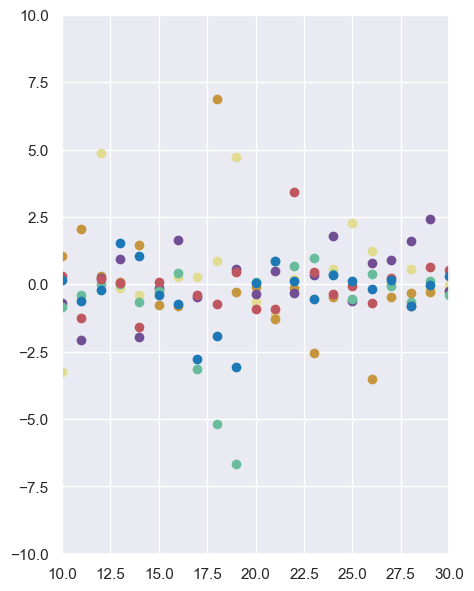

In [345]:
fig,ax= plt.subplots(1, 1,figsize=(5, 7))
ax.plot(neuron_permute_loc,neuron_response_df.x7[-125::],'o', c = colors[1])
ax.plot(neuron_permute_loc,neuron_response_df.x8[-125::],'o', c = colors[2])
ax.plot(neuron_permute_loc,neuron_response_df.x9[-125::],'o', c = colors[3])
ax.plot(neuron_permute_loc,neuron_response_df.x10[-125::],'o', c = colors[4])
ax.plot(neuron_permute_loc,neuron_response_df.x11[-125::],'o', c = colors[5])
ax.plot(neuron_permute_loc,neuron_response_df.x12[-125::],'o', c = colors[6])
ax.set_ylim([-10,10])
ax.set_xlim([10,30])

In [341]:
neuron_response_df.x7[-125::]

62375    4.724373
62376    1.402381
62377   -0.784228
62378   -3.260082
62379   -0.959616
           ...   
62495    0.158145
62496   -0.004149
62497    0.180209
62498   -0.272313
62499   -0.826828
Name: x7, Length: 125, dtype: float64

In [339]:
neuron_response_df

x1         x2         x3        x4         x5        x6  \
0     -8.592693  -7.237817  -8.460794 -6.898249 -10.382250 -9.276602   
1     -3.374927  -8.423330  -4.123425 -4.368222  -3.818843 -3.449127   
2     -8.034200  -8.334540  -5.806151 -5.458295  -6.958843 -6.055831   
3     -6.201544  -5.268112  -7.162717 -6.166777  -7.809368 -7.372465   
4     -9.194510  -7.623813  -4.806454 -6.105420  -6.352255 -5.993083   
...         ...        ...        ...       ...        ...       ...   
62495 -2.770151  -2.994643  -8.732548 -4.409251  -3.475882 -9.194577   
62496 -4.331293  -3.706480  -9.617573 -4.357055  -2.730555 -4.570751   
62497 -5.302287  -3.344162 -11.758846 -4.504711  -3.720913 -5.935485   
62498 -8.878267  -4.158775  -9.434139 -4.936076  -4.428847 -5.895618   
62499 -6.843560 -14.411331 -10.094395 -6.744768  -5.728036 -4.452203   

             x7         x8        x9        x10       x11       x12       x13  \
0      1.029052   2.403573 -1.453994  -0.277764 -5.112518  3.057865  0.229158   
1      0.584352  -0.435532 -0.282211   0.393329 -0.491850 -0.168527  0.021418   
2      1.228856  -1.883082  0.479021   1.456811 -0.282920  0.626243  4.874830   
3      0.477052  -5.641198 -0.478913   0.402087  0.708832  0.047151  1.460494   
4     -0.543112   0.516669  2.250030 -12.003169  2.660048  3.966314  0.334988   
...         ...        ...       ...        ...       ...       ...       ...   
62495  0.158145  11.593369 -0.948988  -0.496607 -0.088201 -0.131241  0.039268   
62496 -0.004149   5.745616  1.054531  -0.556468  0.203175 -0.249467  0.011596   
62497  0.180209   5.761189  0.074049  -0.334517  0.292990 -0.202598  0.092781   
62498 -0.272313   4.580330  0.025168  -0.535403  0.224693 -0.092263  0.814904   
62499 -0.826828   1.339485 -0.673080  -0.024577 -0.110613  0.040644  2.532869   

             x14       x15         x16        x17        x18  
0       2.161143  1.104376    0.284392  14.159801   1.985825  
1       0.247610  0.797382    0.071392   0.051343   0.011434  
2       6.533983  0.214400    1.032126   0.043122   0.850861  
3       8.190146  0.264157    2.204596   0.465534   1.667647  
4       0.144186  0.471207  254.214021  28.677812  13.913761  
...          ...       ...         ...        ...        ...  
62495  26.262101  0.745809    0.167667   0.015553   0.185986  
62496   7.142364  0.711849    0.212511   0.051137   0.023191  
62497  45.534385  0.485304    0.237386   0.061513   0.017719  
62498  62.265251  0.366972    0.174699   0.025910   0.017296  
62499   2.820183  0.469339    0.114838   0.065747   0.014607  

[62500 rows x 18 columns]

In [303]:
len(np.exp(neuron_response_df.x1[-125::]))

125

In [280]:
latent_event_history_df

assignment_id   timestamp  seq_type  seq_warp   amplitude
0                 1.0   11.117005       5.0       1.0  570.201354
1                 2.0   24.433087       5.0       1.0  139.750854
2                 3.0   41.002433       5.0       1.0  625.677765
3                 4.0   54.148715       5.0       1.0  510.194204
4                 5.0   26.083070       1.0       1.0  150.474008
...               ...         ...       ...       ...         ...
679687         1830.0  593.883886       6.0       1.0   10.669645
679688         1831.0  586.644734       4.0       1.0   17.132559
679689         1832.0  590.366349       2.0       1.0   11.953080
679690         1833.0  572.734233       5.0       1.0    2.944672
679691           -1.0   -1.000000      -1.0      -1.0   -1.000000

[679692 rows x 5 columns]

In [288]:
resp_prop_df

neuron                                    response_prob_1  \
0         1  [-13.953012473951484, -9.213076212370652, -8.8...   
1         2  [-14.019340557412674, -14.989736718007116, -10...   
2         3  [-9.862296351211054, -13.151374079889225, -10....   
3         4  [-6.362414958877858, -7.1784661287539935, -6.9...   
4         5  [-7.818593761083012, -8.157535188978338, -7.92...   
..      ...                                                ...   
120     121  [-2.7648805662258904, -2.809868408119255, -2.8...   
121     122  [-3.994465109984804, -4.171137184128069, -4.13...   
122     123  [-4.842249428542738, -4.636517299129378, -4.69...   
123     124  [-7.708097484878309, -7.447102639432435, -8.56...   
124     125  [-8.858381071970635, -9.752349359789743, -10.1...   

                                       response_prob_2  \
0    [-9.026675390482612, -9.407288408850697, -8.88...   
1    [-7.704818552625224, -10.87669274924389, -7.67...   
2    [-9.362767484393624, -10.833285297000163, -8.0...   
3    [-8.00782751304348, -8.88610810949498, -8.7273...   
4    [-5.409077545475756, -5.590086894493553, -6.21...   
..                                                 ...   
120  [-2.8340836792695665, -2.6942667193447285, -2....   
121  [-3.718236540108813, -3.5635297903717102, -3.4...   
122  [-3.2950298751480345, -3.3919882854726278, -3....   
123  [-4.136890743614463, -4.351625622872335, -4.42...   
124  [-5.905277110982698, -6.423460615926887, -6.74...   

                                       response_prob_3  \
0    [-9.676606582924428, -8.360553240430637, -8.56...   
1    [-5.240427290861157, -5.220467500248494, -5.31...   
2    [-5.345605320270348, -5.587505795242812, -5.47...   
3    [-6.520179581365097, -6.660861017205463, -6.32...   
4    [-4.757079810720221, -4.76599549945396, -4.672...   
..                                                 ...   
120  [-9.171259683623274, -8.759640052075484, -8.26...   
121  [-8.217889124663149, -10.117755685198151, -10....   
122  [-10.42955430349502, -9.54303336445133, -9.946...   
123  [-9.20215770670193, -10.382313204083331, -9.29...   
124  [-7.993425522194887, -8.343900666009644, -8.18...   

                                       response_prob_4  \
0    [-9.183276763243748, -8.402655368756355, -8.85...   
1    [-9.02769911279035, -12.40207091739968, -12.81...   
2    [-7.701405472426841, -7.120743708349776, -8.03...   
3    [-8.880299182099495, -8.781471879723195, -9.24...   
4    [-7.088871920797681, -7.27379106811967, -6.867...   
..                                                 ...   
120  [-4.406301602264897, -4.25502115467415, -4.436...   
121  [-4.319509640044554, -4.416514562963163, -4.32...   
122  [-4.405559664178643, -4.365248247727665, -4.48...   
123  [-5.191097179250578, -4.687318385052178, -5.03...   
124  [-6.603554779310291, -6.936630761044772, -6.02...   

                                       response_prob_5  \
0    [-9.447157620502711, -12.247140294419232, -12....   
1    [-3.9074909051958575, -4.016668167573783, -3.9...   
2    [-6.786850485075173, -6.975749094529579, -7.00...   
3    [-6.213386863963048, -6.325152336774633, -6.31...   
4    [-5.045238676671636, -5.130867306970794, -5.04...   
..                                                 ...   
120  [-3.40838659551483, -3.48811614891684, -3.4685...   
121  [-2.754201770907866, -2.7242951620679645, -2.7...   
122  [-3.887249389220951, -3.8533471525220953, -3.7...   
123  [-4.402832032976773, -4.370168077433718, -4.42...   
124  [-5.943321212615342, -6.289817171347142, -6.07...   

                                       response_prob_6  
0    [-9.716354397271791, -10.97968813089972, -11.5...  
1    [-2.692674491752687, -2.70772696426045, -2.697...  
2    [-5.895954241244126, -5.690809636391406, -5.93...  
3    [-7.5180550967239235, -7.511225421586964, -6.8...  
4    [-6.900853714881354, -7.044709313390633, -6.72...  
..                                                 ...  
120  [-7.880845232720546,

In [ ]:
    background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
    ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp - mid_point_time, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.2)

    
    background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
    c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp- mid_point_time, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=0.5)

In [189]:
len(unmasked_spikes_df[mask][seq_mask])

3

In [ ]:
# for each latent:
# find the spikes that are involved
# and the neuron ids

### ignore neurons that dont make the threshold for responsiveness ! 
## maybe even just take the neurons that I subselect in my figures (non background)

## clean up this analysis and try making it about amplitude? 

## pull out perfect sequences: plot thess in space, and plot PPseq rasters for this. then do the average trajectory to make standard task space. 
## also for perfect sequences find how often each sequecnce appears in it - eg. blue green, yellow, purple (100%) the others less often. 


In [ ]:
# plot the amplitude and offset plot
# plot number of sequences each neuron appears in
# plot frequency that neurons appear in dominant sequence (colored by the plot above)

 93%|██████████████████████████████████████████████████████████████████████████▏     | 116/125 [00:14<00:01,  8.17it/s]


KeyboardInterrupt: 

In [272]:
offset_df.offset_1[0]

[50000    1.544545
 Name: x7, dtype: float64,
 50125   -14.799216
 Name: x7, dtype: float64,
 50250   -1.730945
 Name: x7, dtype: float64,
 50375    0.276508
 Name: x7, dtype: float64,
 50500   -1.646915
 Name: x7, dtype: float64,
 50625   -0.988008
 Name: x7, dtype: float64,
 50750    0.531554
 Name: x7, dtype: float64,
 50875   -0.669188
 Name: x7, dtype: float64,
 51000    0.856479
 Name: x7, dtype: float64,
 51125    11.187386
 Name: x7, dtype: float64,
 51250   -0.658623
 Name: x7, dtype: float64,
 51375    2.256537
 Name: x7, dtype: float64,
 51500    9.202542
 Name: x7, dtype: float64,
 51625   -7.737878
 Name: x7, dtype: float64,
 51750    0.971195
 Name: x7, dtype: float64,
 51875   -0.524354
 Name: x7, dtype: float64,
 52000    0.307152
 Name: x7, dtype: float64,
 52125    0.081204
 Name: x7, dtype: float64,
 52250   -0.577908
 Name: x7, dtype: float64,
 52375   -2.916314
 Name: x7, dtype: float64,
 52500    1.602717
 Name: x7, dtype: float64,
 52625    1.74114
 Name: x7, dty

In [292]:
len(all_std_mean_resp_prop)

125

In [284]:
resp_prop_df

neuron                                    response_prob_1  \
0         1  [-13.953012473951484, -9.213076212370652, -8.8...   
1         2  [-14.019340557412674, -14.989736718007116, -10...   
2         3  [-9.862296351211054, -13.151374079889225, -10....   
3         4  [-6.362414958877858, -7.1784661287539935, -6.9...   
4         5  [-7.818593761083012, -8.157535188978338, -7.92...   
..      ...                                                ...   
120     121  [-2.7648805662258904, -2.809868408119255, -2.8...   
121     122  [-3.994465109984804, -4.171137184128069, -4.13...   
122     123  [-4.842249428542738, -4.636517299129378, -4.69...   
123     124  [-7.708097484878309, -7.447102639432435, -8.56...   
124     125  [-8.858381071970635, -9.752349359789743, -10.1...   

                                       response_prob_2  \
0    [-9.026675390482612, -9.407288408850697, -8.88...   
1    [-7.704818552625224, -10.87669274924389, -7.67...   
2    [-9.362767484393624, -10.833285297000163, -8.0...   
3    [-8.00782751304348, -8.88610810949498, -8.7273...   
4    [-5.409077545475756, -5.590086894493553, -6.21...   
..                                                 ...   
120  [-2.8340836792695665, -2.6942667193447285, -2....   
121  [-3.718236540108813, -3.5635297903717102, -3.4...   
122  [-3.2950298751480345, -3.3919882854726278, -3....   
123  [-4.136890743614463, -4.351625622872335, -4.42...   
124  [-5.905277110982698, -6.423460615926887, -6.74...   

                                       response_prob_3  \
0    [-9.676606582924428, -8.360553240430637, -8.56...   
1    [-5.240427290861157, -5.220467500248494, -5.31...   
2    [-5.345605320270348, -5.587505795242812, -5.47...   
3    [-6.520179581365097, -6.660861017205463, -6.32...   
4    [-4.757079810720221, -4.76599549945396, -4.672...   
..                                                 ...   
120  [-9.171259683623274, -8.759640052075484, -8.26...   
121  [-8.217889124663149, -10.117755685198151, -10....   
122  [-10.42955430349502, -9.54303336445133, -9.946...   
123  [-9.20215770670193, -10.382313204083331, -9.29...   
124  [-7.993425522194887, -8.343900666009644, -8.18...   

                                       response_prob_4  \
0    [-9.183276763243748, -8.402655368756355, -8.85...   
1    [-9.02769911279035, -12.40207091739968, -12.81...   
2    [-7.701405472426841, -7.120743708349776, -8.03...   
3    [-8.880299182099495, -8.781471879723195, -9.24...   
4    [-7.088871920797681, -7.27379106811967, -6.867...   
..                                                 ...   
120  [-4.406301602264897, -4.25502115467415, -4.436...   
121  [-4.319509640044554, -4.416514562963163, -4.32...   
122  [-4.405559664178643, -4.365248247727665, -4.48...   
123  [-5.191097179250578, -4.687318385052178, -5.03...   
124  [-6.603554779310291, -6.936630761044772, -6.02...   

                                       response_prob_5  \
0    [-9.447157620502711, -12.247140294419232, -12....   
1    [-3.9074909051958575, -4.016668167573783, -3.9...   
2    [-6.786850485075173, -6.975749094529579, -7.00...   
3    [-6.213386863963048, -6.325152336774633, -6.31...   
4    [-5.045238676671636, -5.130867306970794, -5.04...   
..                                                 ...   
120  [-3.40838659551483, -3.48811614891684, -3.4685...   
121  [-2.754201770907866, -2.7242951620679645, -2.7...   
122  [-3.887249389220951, -3.8533471525220953, -3.7...   
123  [-4.402832032976773, -4.370168077433718, -4.42...   
124  [-5.943321212615342, -6.289817171347142, -6.07...   

                                       response_prob_6  
0    [-9.716354397271791, -10.97968813089972, -11.5...  
1    [-2.692674491752687, -2.70772696426045, -2.697...  
2    [-5.895954241244126, -5.690809636391406, -5.93...  
3    [-7.5180550967239235, -7.511225421586964, -6.8...  
4    [-6.900853714881354, -7.044709313390633, -6.72...  
..                                                 ...  
120  [-7.880845232720546,

In [275]:
#remove neurons wiht response prop that is subtrheshold: 

# sort based on type and size of type:
index_max = []
resp_size = []
biggest_resp_offset = []
 
for _, item in enumerate(all_mean_mean_resp_prop):
    index_max += [np.argmax(item)]
    resp_size += [item[np.argmax(item)]]
    # offset val for the largest resp prop 
    biggest_resp_offset += [all_mean_mean_offset[_][np.argmax(item)]]

# remove 20% least responsive neurons
has_response = resp_size > np.quantile(resp_size, 0.2)

index_max_ = np.array(index_max)[has_response]
resp_size_ = np.array(resp_size)[has_response]
biggest_resp_offset_ = np.array(biggest_resp_offset)[has_response]
    
# sort:
ind = np.lexsort((resp_size_,index_max_))
offset_ind = np.lexsort((biggest_resp_offset_,index_max_))

    
permuted_respprops = [item for sublist in (np.array(all_mean_mean_resp_prop)[has_response][ind]) for item in sublist]
permuted_offset = [item for sublist in (np.array(all_mean_mean_offset)[has_response][offset_ind]) for item in sublist]

(0.005, 0.07)

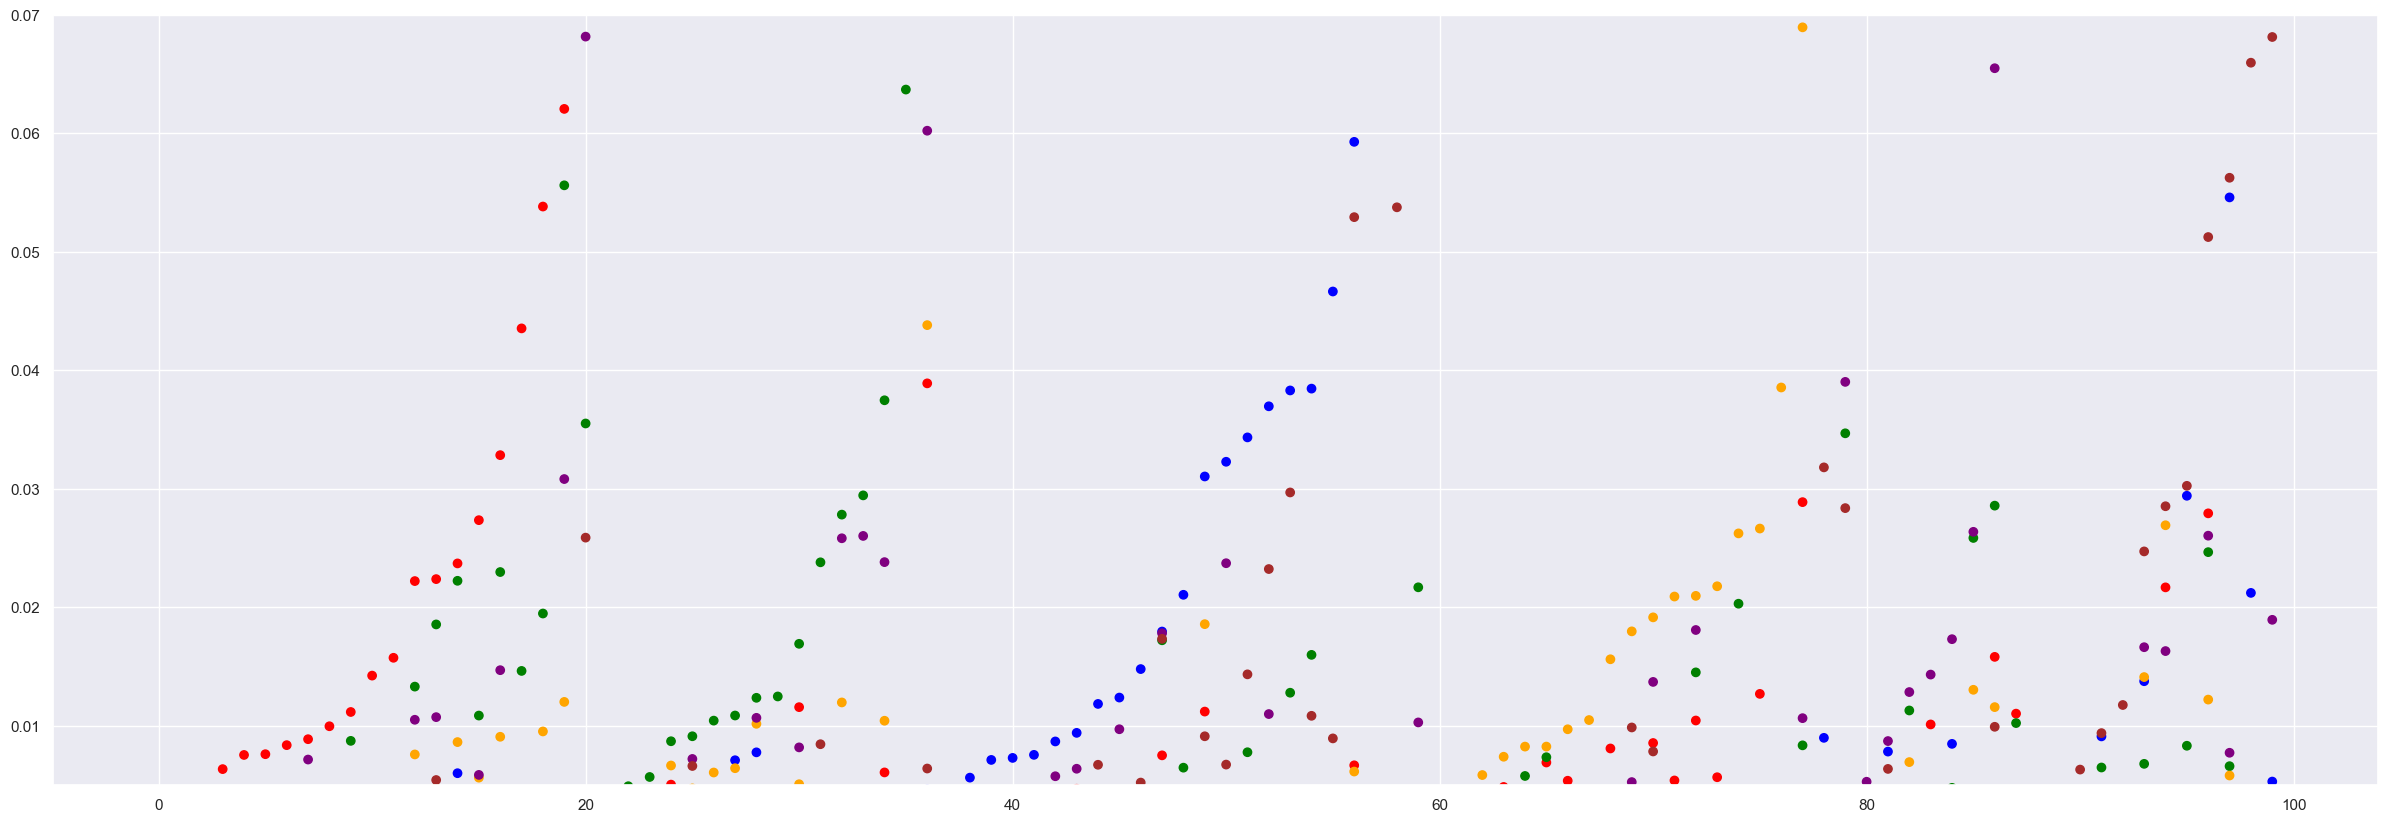

In [276]:
fig, ax = plt.subplots(1, 1,figsize=(30, 10))

ax.scatter(all_index_rp[0:len(permuted_respprops)],permuted_respprops,marker='o',c = (['red','green','blue','orange','purple','brown'] *int((len(permuted_respprops)/6))) ,alpha = 1)

ax.set_ylim(0.005,0.07)

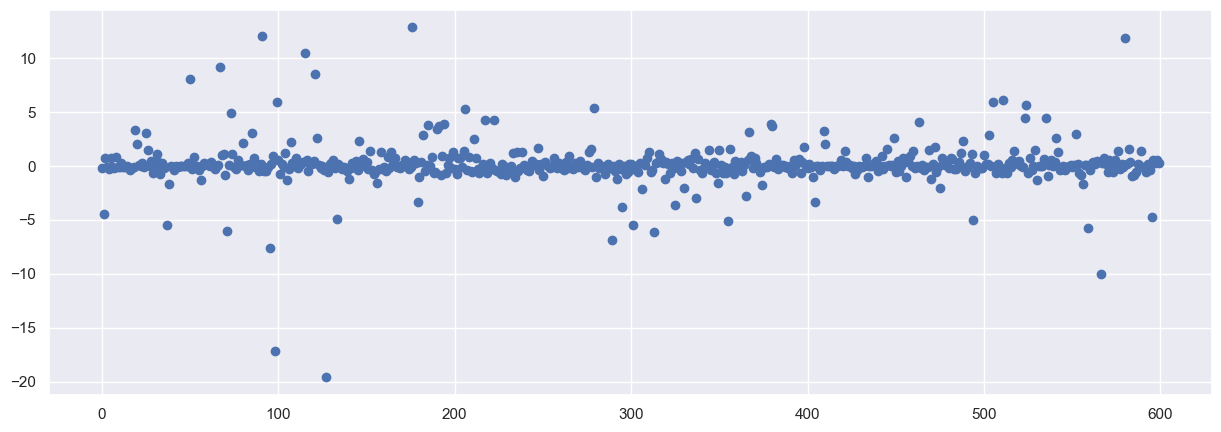

In [277]:
fig, ax = plt.subplots(1, 1,figsize=(15, 5))

ax.scatter(list(range(0,len(permuted_offset))),permuted_offset,marker='o',alpha = 1)


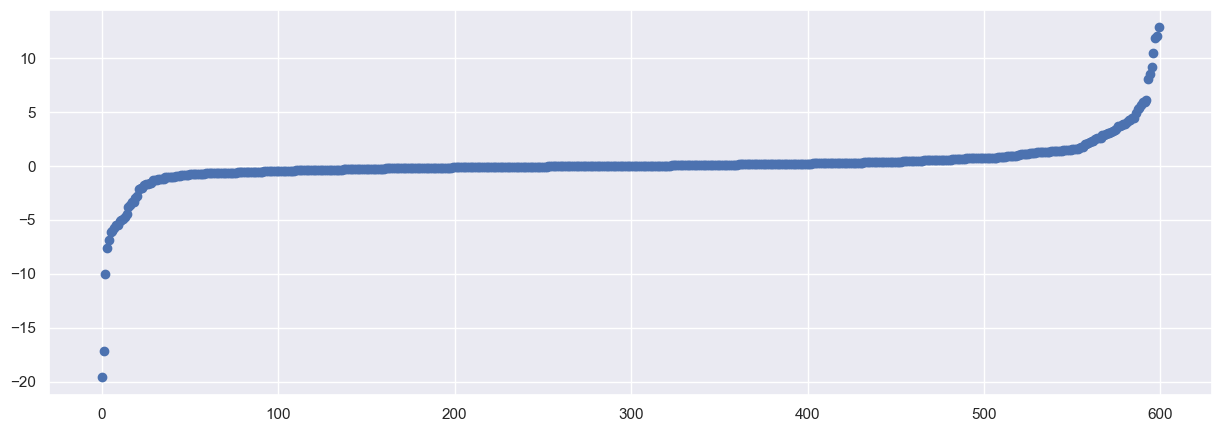

In [278]:
fig, ax = plt.subplots(1, 1,figsize=(15, 5))

ax.scatter(list(range(0,len(permuted_offset))),np.sort(permuted_offset),marker='o',alpha = 1)

In [ ]:
np.sort(permuted_offset)

In [ ]:
permuted_offset.sort